In [ ]:
#!pip install tensorflow==1.13.1
#!pip install keras 2.2.4

In [1]:
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt

import tensorflow as tf
import keras
#from keras import backend as K
from tensorflow.keras import backend as K
from keras import initializers
from keras.layers import Dense, Input, Activation, multiply
from keras.models import Sequential, Model, load_model
from keras.layers.merge import add, concatenate


/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/apps/share64/debian7/ana

In [26]:
act_dict = {0: 'linear', 1: 'multiply', 2: 'inverse', 3: 'squared', 4: 'sqrt'}
np.random.seed(100000)
weight_dict = {0: 0, 1: 1, 2: np.random.uniform(0.0,1.0,1)[0]}
bias_dict = {0: 0, 1: 1, 2: np.random.uniform(0.0,0.001,1)[0]}
nact_terms = 9
nweight_terms = 28
nbias_terms = 9

In [27]:
df = pd.read_csv('CHNO_data.csv')
print (df.shape)
df.head()

(149, 21)


,Explosive,C,H,N,O,Al,B,Ba,Ca,Cl,...,P,Pb,Si,Heat of Formation [kcal/mol],Density [g/cc],D (exp) [km/s],N_arb,M_arb,Q_arb,D_KJ
0,"1,3,5-Triamino-2,4,6-trinitrobenzene",6.0,6.0,6.0,6.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-33.398140,1.80,7.35,0.029070,27.200,1089.154,7.545764
1,"1,3,5-Trinitrobenzene",6.0,3.0,3.0,6.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-10.399280,1.71,7.30,0.024648,32.000,1351.177,7.369484
2,"2,4,6,2',4',6'-Hexanitrodiphenylamine",12.0,5.0,7.0,12.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,9.882000,1.60,7.20,0.024487,32.744,1368.752,7.082862
3,"2,4,6-Trinitrocresol",7.0,5.0,3.0,7.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-60.288800,1.62,6.85,0.025720,29.760,1216.919,6.940381
4,"3-Nitro-1,2,4-triazole-5-one",2.0,2.0,4.0,3.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-24.086714,1.80,7.89,0.030769,29.500,982.410,7.720667


In [28]:
df = df.round({'Heat of Formation [kcal/mol]': 3, 'Density [g/cc]': 3, 'D (exp) [km/s]': 3})

In [29]:
inputs = np.array(df[['C','H','N','O','Heat of Formation [kcal/mol]','Density [g/cc]']])

outputs = np.array(df['D (exp) [km/s]'])


print (inputs.shape, outputs.shape)

#train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs, outputs, test_size=0.20, random_state=2)
#print (train_inputs.shape, train_outputs.shape)
#print (test_inputs.shape, test_outputs.shape)

(149, 6) (149,)


In [30]:
#inputs

In [31]:
def squared_act(x):
    return x*x

def inv_act(x):
    return x**(-1)

def sqrt_act(x):
    return x**(1/2)



In [32]:
class CustomDense(keras.layers.Layer):
    def __init__(self, num_units, input_num, activation, name, trainable_weight, trainable_bias):
        super(CustomDense, self).__init__()
        self.num_units = num_units
        self.activation = Activation(activation)
        self.trainable_weight = trainable_weight
        self.trainable_bias = trainable_bias
        self.name = name
        name_w = 'w'+self.name[1:]
        name_b = 'b'+self.name[1:]
        self.weight = self.add_weight(shape=(input_num, self.num_units), name=name_w, trainable=self.trainable_weight, initializer="zeros")
        self.bias = self.add_weight(shape=(self.num_units,), name=name_b, trainable=self.trainable_bias, initializer="zeros")
        
    def call(self, input):
        y = tf.matmul(input, self.weight) + self.bias
        y = self.activation(y)
        return y


In [33]:
def create_node1(input1, input2, input3, input4, name, trainable1, trainable2, trainable3, trainable4, act, bias):
    base = name
    n1 = base + "1"
    n2 = base + "2"
    n3 = base + "3"
    n4 = base + "4"
    
    an1 = CustomDense(1, 1, activation = 'linear', name=n1, trainable_weight=trainable1, trainable_bias = 0) (input1)
    an2 = CustomDense(1, 1, activation = 'linear', name=n2, trainable_weight=trainable2, trainable_bias = 0) (input2)
    an3 = CustomDense(1, 1, activation = 'linear', name=n3, trainable_weight=trainable3, trainable_bias = 0) (input3)
    an4 = CustomDense(1, 1, activation = 'linear', name=n4, trainable_weight=trainable4, trainable_bias = bias) (input4)
    
    if (act == "multiply"):
        an = multiply([an1, an2, an3, an4])
    
    else:
        an = add([an1, an2, an3, an4])
        if (act == "inverse"):
            an = Activation(inv_act) (an)
        elif (act == "squared"):
            an = Activation(squared_act) (an)
        elif (act == "sqrt"):
            an = Activation(sqrt_act) (an)
        else:
            an = Activation(act) (an)
    return an

def create_node2(input5, input6, name, trainable5, trainable6, act, bias):
    base = name
    
    n5 = base + "5"
    n6 = base + "6"
    
    an5 = CustomDense(1, 1, activation = 'linear', name=n5, trainable_weight=trainable5, trainable_bias = 0) (input5)
    an6 = CustomDense(1, 1, activation = 'linear', name=n6, trainable_weight=trainable6, trainable_bias=bias) (input6)
    if (act == "multiply"):
        an = multiply([an5, an6])
    
    else:
        an = add([an5, an6])
        if (act == "inverse"):
            an = Activation(inv_act) (an)
        elif (act == "squared"):
            an = Activation(squared_act) (an)
        elif (act == "sqrt"):
            an = Activation(sqrt_act) (an)
        else:
            an = Activation(act) (an)
    return an

def create_output(a7, a8, name, trainable1, trainable2, act, bias):
    base = name
    n7 = base + "7"
    n8 = base + "8"
  
    an7 = CustomDense(1, 1, activation = 'linear', name=n7, trainable_weight=trainable1, trainable_bias = 0) (a7)
    an8 = CustomDense(1, 1, activation = 'linear', name=n8, trainable_weight=trainable2, trainable_bias = bias) (a8)
    
    if (act == "multiply"):
        an = multiply([an7, an8])
    
    else:
        an = add([an7, an8])
        if (act == "inverse"):
            an = Activation(inv_act) (an)
        elif (act == "squared"):
            an = Activation(squared_act) (an)
        elif (act == "sqrt"):
            an = Activation(sqrt_act) (an)
        else:
            an = Activation(act) (an)
    return an

In [34]:
def create_model(x):
    #initializer = keras.initializers.RandomUniform(minval=-0.001, maxval=0.001, seed=0)
    bias_initial = keras.initializers.Zeros()

    trainable_list = []
    for i in range(nweight_terms):
        if (x[i+nact_terms] == 2):
            trainable_list.append(True)
        else:
            trainable_list.append(False)
    
    for i in range(nbias_terms):
        if (x[i+nact_terms+nweight_terms] == 2):
            trainable_list.append(True)
        else:
            trainable_list.append(False)

    input1 = Input(shape=(1,))
    input2 = Input(shape=(1,))
    input3 = Input(shape=(1,))
    input4 = Input(shape=(1,))
    input5 = Input(shape=(1,))
    input6 = Input(shape=(1,))

    a1 = create_node1(input1, input2, input3, input4, "a1", trainable_list[0], trainable_list[1], trainable_list[2], trainable_list[3], act_dict[x[0]], trainable_list[28])
    a2 = create_node1(input1, input2, input3, input4, "a2", trainable_list[4], trainable_list[5], trainable_list[6], trainable_list[7], act_dict[x[1]], trainable_list[29])
    a3 = create_node1(input1, input2, input3, input4, "a3", trainable_list[8], trainable_list[9], trainable_list[10], trainable_list[11], act_dict[x[2]], trainable_list[30])
    a4 = create_node1(input1, input2, input3, input4, "a4", trainable_list[12], trainable_list[13], trainable_list[14], trainable_list[15], act_dict[x[3]], trainable_list[31])
    
    a5 = create_node2(input5, input6, "a5", trainable_list[16], trainable_list[17], act_dict[x[4]], trainable_list[32])
    a6 = create_node2(input5, input6, "a6", trainable_list[18], trainable_list[19], act_dict[x[5]], trainable_list[33])
    
    a7 = create_node1(a1, a2, a3, a4, "a7", trainable_list[20], trainable_list[21], trainable_list[22], trainable_list[23], act_dict[x[6]], trainable_list[34])
    a8 = create_node2(a5, a6, "a8", trainable_list[24], trainable_list[25], act_dict[x[7]], trainable_list[35])

    output = create_output(a7, a8, "output", trainable_list[26], trainable_list[27], act_dict[x[8]], trainable_list[36])

    model = Model(inputs=[input1, input2, input3, input4, input5, input6], outputs=output)
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
    model.compile(loss='mse', optimizer=optimizer)
    
    layer_list = []
    for i in range(len(model.layers)):
        name = model.layers[i].name
        if ( ("activation" in name) or ("input" in name) or ("add" in name) or ("multiply" in name) ):
            continue
        else:
            layer_list.append(i)
    
    for i in range(len(layer_list)):
                
        #if (model.layers[layer_list[i]].get_weights()[0].shape==(1,1)):
         #   model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ),  np.array( [ bias_dict[x[nact_terms+nweight_terms+i]] ] ) ] )
        #else:
         #   model.layers[layer_list[i]].set_weights( [ np.array( [ bias_dict[x[nact_terms+nweight_terms+i]] ] ),  np.array( [[ weight_dict[x[nact_terms+i]] ]] ) ] )
        
        name = model.layers[layer_list[i]].name
        if (("a14" in name) or ("a24" in name) or ("a34" in name) or ("a44" in name) or ("a56" in name) or ("a66" in name) or ("a74" in name) or ("a86" in name) or ("output8" in name)):
        
            if (model.layers[layer_list[i]].get_weights()[0].shape==(1,1)):
                model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ),  np.array( [ bias_dict[x[nact_terms+nweight_terms+int((i+1)/9)]] ] ) ] )
            else:
                model.layers[layer_list[i]].set_weights( [ np.array( [ bias_dict[x[nact_terms+nweight_terms+int((i+1)/9)]] ] ),  np.array( [[ weight_dict[x[nact_terms+i]] ]] ) ] )
            
        else:
            model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ), np.array( [0.] ) ] )

    model.summary()

    return model, trainable_list

In [35]:
losses = []
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + ' Loss: ' + str(logs.get('loss')) + '                     \n')
        losses.append(logs.get('loss'))
        
class ValidLossNaN(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if np.isnan(logs.get('loss')):
            self.model.stop_training=True

def train(model, train_inputs, train_outputs, verbose=False):
    mae_es= keras.callbacks.EarlyStopping(monitor='val_loss', patience=500,
                                          min_delta=1e-4, verbose=1, mode='auto', restore_best_weights=True)
    
    terminate = keras.callbacks.TerminateOnNaN()
    
    EPOCHS = 10000 # Number of EPOCHS
    history = model.fit([train_inputs[:,0], train_inputs[:,1], train_inputs[:,2], train_inputs[:,3], train_inputs[:,4], train_inputs[:,5]], train_outputs, epochs=EPOCHS,
                        shuffle=False, batch_size=len(train_inputs), verbose = False, callbacks=[terminate, PrintEpNum(), mae_es, ValidLossNaN()],
                        validation_split=0.2)

    if verbose:
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Sq Error')
        plt.plot(history.epoch, np.array(history.history['loss']),label='Training loss')
        plt.legend()
        plt.show()
    return history

In [36]:
def cv_error(individual, inputs, outputs):
    kf = KFold(n_splits=10, shuffle=True, random_state = 42)
    kf.get_n_splits(inputs)

    
    
    
    cv_mse_list = []
    train_preds_list = []
    test_preds_list = []
    train_outputs_list = []
    test_outputs_list = []
    

    for train_index, test_index in kf.split(inputs):
        #print(train_index, test_index)
        new_model, trainable = create_model(individual)
        
        train_inputs, test_inputs = inputs[train_index], inputs[test_index]
        train_outputs, test_outputs = outputs[train_index], outputs[test_index]
        
        if (any(trainable) == True):
    
            train(new_model, train_inputs, train_outputs, verbose=False)

            wt_bs = new_model.get_weights()
            weight_list = []
            bias_list = []

            for weight in wt_bs:
                if (weight.shape == (1,1)):
                    weight_list.append(weight[0])
                else:
                    bias_list.append(weight[0])
                

                #handle nan weights
            if (np.isnan(weight_list).any()):
                cv_mse = 1e50
            elif (np.isnan(np.array(bias_list)).any()):
                cv_mse = 1e50
            else:
                cv_mse = new_model.evaluate([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:,3], test_inputs[:,4], test_inputs[:,5]], test_outputs)
                test_preds = np.around(new_model.predict([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:,3], test_inputs[:,4], test_inputs[:,5]]),decimals=3)
                train_preds = np.around(new_model.predict([train_inputs[:, 0], train_inputs[:, 1], train_inputs[:, 2], train_inputs[:, 3], train_inputs[:, 4], train_inputs[:, 5]]),decimals=3)
                

                if (np.isnan(cv_mse)):
                    cv_mse = 1e50
                else:
                    cv_mse = np.around(cv_mse,decimals=6)

            cv_mse_list.append(cv_mse)
            train_preds_list.append(train_preds)
            test_preds_list.append(test_preds)
            train_outputs_list.append(train_outputs)
            test_outputs_list.append(test_outputs)
        
        else:
            wt_bs = new_model.get_weights()
            weight_list = []
            bias_list = []

            for weight in wt_bs:
                if (weight.shape == (1,1)):
                    weight_list.append(weight[0])
                else:
                    bias_list.append(weight[0])

            if (np.isnan(np.array(weight_list)).any()):
                cv_mse=1e50
            elif (np.isnan(np.array(bias_list)).any()):
                cv_mse = 1e50

            else:
                cv_mse = new_model.evaluate([test_inputs[:,0],test_inputs[:,1],test_inputs[:,2],test_inputs[:,3], test_inputs[:,4], test_inputs[:,5]], test_outputs)

                if (np.isnan(cv_mse)):
                    cv_mse = 1e50
                else:
                    cv_mse = np.around(cv_mse,decimals=6)

            cv_mse_list.append(cv_mse)
        
        
        
    print(cv_mse_list)
    return np.mean(cv_mse_list), train_preds_list, test_preds_list, train_outputs_list, test_outputs_list

In [37]:
def f3(w):
    return w

In [38]:
#individual = [2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0]  # kj
#individual = [2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0]

individual = []
for i in range(46):
    if i < 9:
        individual.append(0)
    else:
        individual.append(2)
#new_model, trainable = create_model(individual)


In [39]:
mse_term, train_preds_list, test_preds_list, train_outputs_list, test_outputs_list = cv_error(individual, inputs, outputs)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
____________________

Current Epoch: 1 Loss: 48.34892654418945                     
Current Epoch: 2 Loss: 42.108314514160156                     
Current Epoch: 3 Loss: 36.451988220214844                     
Current Epoch: 4 Loss: 31.35122299194336                     
Current Epoch: 5 Loss: 26.780982971191406                     
Current Epoch: 6 Loss: 22.721704483032227                     
Current Epoch: 7 Loss: 19.160572052001953                     
Current Epoch: 8 Loss: 16.092008590698242                     
Current Epoch: 9 Loss: 13.517083168029785                     
Current Epoch: 10 Loss: 11.441174507141113                     
Current Epoch: 11 Loss: 9.869508743286133                     
Current Epoch: 12 Loss: 8.800041198730469                     
Current Epoch: 13 Loss: 8.213641166687012                     
Current Epoch: 14 Loss: 8.062910079956055                     
Current Epoch: 15 Loss: 8.26344108581543                     
Current Epoch: 16 Loss: 8.693906784057617                

Current Epoch: 131 Loss: 4.492105484008789                     
Current Epoch: 132 Loss: 4.472485065460205                     
Current Epoch: 133 Loss: 4.4530534744262695                     
Current Epoch: 134 Loss: 4.433809757232666                     
Current Epoch: 135 Loss: 4.414751052856445                     
Current Epoch: 136 Loss: 4.395875930786133                     
Current Epoch: 137 Loss: 4.377180576324463                     
Current Epoch: 138 Loss: 4.358666896820068                     
Current Epoch: 139 Loss: 4.340332508087158                     
Current Epoch: 140 Loss: 4.322177410125732                     
Current Epoch: 141 Loss: 4.304200172424316                     
Current Epoch: 142 Loss: 4.28640079498291                     
Current Epoch: 143 Loss: 4.268779754638672                     
Current Epoch: 144 Loss: 4.251334190368652                     
Current Epoch: 145 Loss: 4.23406457901001                     
Current Epoch: 146 Loss: 4.21696805953979

Current Epoch: 259 Loss: 2.888604164123535                     
Current Epoch: 260 Loss: 2.87860107421875                     
Current Epoch: 261 Loss: 2.8686001300811768                     
Current Epoch: 262 Loss: 2.8586013317108154                     
Current Epoch: 263 Loss: 2.848604202270508                     
Current Epoch: 264 Loss: 2.838608503341675                     
Current Epoch: 265 Loss: 2.8286147117614746                     
Current Epoch: 266 Loss: 2.818622589111328                     
Current Epoch: 267 Loss: 2.8086318969726562                     
Current Epoch: 268 Loss: 2.798642158508301                     
Current Epoch: 269 Loss: 2.788654088973999                     
Current Epoch: 270 Loss: 2.778667449951172                     
Current Epoch: 271 Loss: 2.768681287765503                     
Current Epoch: 272 Loss: 2.758697032928467                     
Current Epoch: 273 Loss: 2.7487142086029053                     
Current Epoch: 274 Loss: 2.738731861

Current Epoch: 387 Loss: 1.6567461490631104                     
Current Epoch: 388 Loss: 1.6483373641967773                     
Current Epoch: 389 Loss: 1.639967918395996                     
Current Epoch: 390 Loss: 1.6316381692886353                     
Current Epoch: 391 Loss: 1.6233487129211426                     
Current Epoch: 392 Loss: 1.615100622177124                     
Current Epoch: 393 Loss: 1.6068936586380005                     
Current Epoch: 394 Loss: 1.5987282991409302                     
Current Epoch: 395 Loss: 1.5906054973602295                     
Current Epoch: 396 Loss: 1.5825254917144775                     
Current Epoch: 397 Loss: 1.5744887590408325                     
Current Epoch: 398 Loss: 1.566495656967163                     
Current Epoch: 399 Loss: 1.558546781539917                     
Current Epoch: 400 Loss: 1.5506426095962524                     
Current Epoch: 401 Loss: 1.5427833795547485                     
Current Epoch: 402 Loss: 1.53

Current Epoch: 514 Loss: 0.9466469883918762                     
Current Epoch: 515 Loss: 0.9432311654090881                     
Current Epoch: 516 Loss: 0.9398305416107178                     
Current Epoch: 517 Loss: 0.9364444613456726                     
Current Epoch: 518 Loss: 0.9330723285675049                     
Current Epoch: 519 Loss: 0.9297140836715698                     
Current Epoch: 520 Loss: 0.9263694882392883                     
Current Epoch: 521 Loss: 0.9230379462242126                     
Current Epoch: 522 Loss: 0.9197190403938293                     
Current Epoch: 523 Loss: 0.9164128303527832                     
Current Epoch: 524 Loss: 0.9131189584732056                     
Current Epoch: 525 Loss: 0.9098369479179382                     
Current Epoch: 526 Loss: 0.9065664410591125                     
Current Epoch: 527 Loss: 0.9033076167106628                     
Current Epoch: 528 Loss: 0.9000597596168518                     
Current Epoch: 529 Loss: 

Current Epoch: 641 Loss: 0.5812288522720337                     
Current Epoch: 642 Loss: 0.5788269639015198                     
Current Epoch: 643 Loss: 0.5764334797859192                     
Current Epoch: 644 Loss: 0.5740487575531006                     
Current Epoch: 645 Loss: 0.5716727375984192                     
Current Epoch: 646 Loss: 0.5693053007125854                     
Current Epoch: 647 Loss: 0.566946804523468                     
Current Epoch: 648 Loss: 0.5645968914031982                     
Current Epoch: 649 Loss: 0.5622556805610657                     
Current Epoch: 650 Loss: 0.5599234104156494                     
Current Epoch: 651 Loss: 0.5575997829437256                     
Current Epoch: 652 Loss: 0.5552852749824524                     
Current Epoch: 653 Loss: 0.5529796481132507                     
Current Epoch: 654 Loss: 0.5506828427314758                     
Current Epoch: 655 Loss: 0.5483951568603516                     
Current Epoch: 656 Loss: 0

Current Epoch: 767 Loss: 0.3510419428348541                     
Current Epoch: 768 Loss: 0.34979304671287537                     
Current Epoch: 769 Loss: 0.34855249524116516                     
Current Epoch: 770 Loss: 0.34732022881507874                     
Current Epoch: 771 Loss: 0.34609633684158325                     
Current Epoch: 772 Loss: 0.3448806405067444                     
Current Epoch: 773 Loss: 0.3436734080314636                     
Current Epoch: 774 Loss: 0.34247422218322754                     
Current Epoch: 775 Loss: 0.34128323197364807                     
Current Epoch: 776 Loss: 0.34010040760040283                     
Current Epoch: 777 Loss: 0.33892592787742615                     
Current Epoch: 778 Loss: 0.33775943517684937                     
Current Epoch: 779 Loss: 0.33660078048706055                     
Current Epoch: 780 Loss: 0.33545053005218506                     
Current Epoch: 781 Loss: 0.33430808782577515                     
Current Epoch

Current Epoch: 893 Loss: 0.2488320767879486                     
Current Epoch: 894 Loss: 0.24837303161621094                     
Current Epoch: 895 Loss: 0.24791817367076874                     
Current Epoch: 896 Loss: 0.24746732413768768                     
Current Epoch: 897 Loss: 0.24702048301696777                     
Current Epoch: 898 Loss: 0.24657775461673737                     
Current Epoch: 899 Loss: 0.24613897502422333                     
Current Epoch: 900 Loss: 0.24570411443710327                     
Current Epoch: 901 Loss: 0.24527320265769958                     
Current Epoch: 902 Loss: 0.24484623968601227                     
Current Epoch: 903 Loss: 0.2444230169057846                     
Current Epoch: 904 Loss: 0.24400374293327332                     
Current Epoch: 905 Loss: 0.24358823895454407                     
Current Epoch: 906 Loss: 0.24317657947540283                     
Current Epoch: 907 Loss: 0.24276860058307648                     
Current Epoc

Current Epoch: 1018 Loss: 0.21505580842494965                     
Current Epoch: 1019 Loss: 0.21492137014865875                     
Current Epoch: 1020 Loss: 0.21478833258152008                     
Current Epoch: 1021 Loss: 0.2146567553281784                     
Current Epoch: 1022 Loss: 0.21452650427818298                     
Current Epoch: 1023 Loss: 0.21439777314662933                     
Current Epoch: 1024 Loss: 0.21427029371261597                     
Current Epoch: 1025 Loss: 0.21414421498775482                     
Current Epoch: 1026 Loss: 0.21401944756507874                     
Current Epoch: 1027 Loss: 0.21389615535736084                     
Current Epoch: 1028 Loss: 0.21377405524253845                     
Current Epoch: 1029 Loss: 0.2136533558368683                     
Current Epoch: 1030 Loss: 0.21353383362293243                     
Current Epoch: 1031 Loss: 0.21341572701931                     
Current Epoch: 1032 Loss: 0.21329885721206665                     


Current Epoch: 1141 Loss: 0.206040158867836                     
Current Epoch: 1142 Loss: 0.2060079723596573                     
Current Epoch: 1143 Loss: 0.20597615838050842                     
Current Epoch: 1144 Loss: 0.20594489574432373                     
Current Epoch: 1145 Loss: 0.20591388642787933                     
Current Epoch: 1146 Loss: 0.20588332414627075                     
Current Epoch: 1147 Loss: 0.20585308969020844                     
Current Epoch: 1148 Loss: 0.20582333207130432                     
Current Epoch: 1149 Loss: 0.20579387247562408                     
Current Epoch: 1150 Loss: 0.2057647705078125                     
Current Epoch: 1151 Loss: 0.20573608577251434                     
Current Epoch: 1152 Loss: 0.20570772886276245                     
Current Epoch: 1153 Loss: 0.2056797742843628                     
Current Epoch: 1154 Loss: 0.2056521624326706                     
Current Epoch: 1155 Loss: 0.20562489330768585                     
C

Current Epoch: 1264 Loss: 0.20406579971313477                     
Current Epoch: 1265 Loss: 0.2040596902370453                     
Current Epoch: 1266 Loss: 0.20405375957489014                     
Current Epoch: 1267 Loss: 0.2040477991104126                     
Current Epoch: 1268 Loss: 0.2040419727563858                     
Current Epoch: 1269 Loss: 0.20403626561164856                     
Current Epoch: 1270 Loss: 0.20403066277503967                     
Current Epoch: 1271 Loss: 0.2040250599384308                     
Current Epoch: 1272 Loss: 0.20401957631111145                     
Current Epoch: 1273 Loss: 0.20401418209075928                     
Current Epoch: 1274 Loss: 0.20400890707969666                     
Current Epoch: 1275 Loss: 0.20400363206863403                     
Current Epoch: 1276 Loss: 0.20399846136569977                     
Current Epoch: 1277 Loss: 0.20399336516857147                     
Current Epoch: 1278 Loss: 0.20398829877376556                     

Current Epoch: 1387 Loss: 0.20372262597084045                     
Current Epoch: 1388 Loss: 0.20372170209884644                     
Current Epoch: 1389 Loss: 0.203720822930336                     
Current Epoch: 1390 Loss: 0.2037198543548584                     
Current Epoch: 1391 Loss: 0.20371899008750916                     
Current Epoch: 1392 Loss: 0.20371821522712708                     
Current Epoch: 1393 Loss: 0.20371736586093903                     
Current Epoch: 1394 Loss: 0.20371653139591217                     
Current Epoch: 1395 Loss: 0.20371578633785248                     
Current Epoch: 1396 Loss: 0.20371492207050323                     
Current Epoch: 1397 Loss: 0.20371413230895996                     
Current Epoch: 1398 Loss: 0.2037132978439331                     
Current Epoch: 1399 Loss: 0.20371264219284058                     
Current Epoch: 1400 Loss: 0.2037118524312973                     
Current Epoch: 1401 Loss: 0.20371109247207642                     


Current Epoch: 1 Loss: 51.67947769165039                     
Current Epoch: 2 Loss: 45.16538619995117                     
Current Epoch: 3 Loss: 39.26631546020508                     
Current Epoch: 4 Loss: 33.949581146240234                     
Current Epoch: 5 Loss: 29.185964584350586                     
Current Epoch: 6 Loss: 24.95159149169922                     
Current Epoch: 7 Loss: 21.22924041748047                     
Current Epoch: 8 Loss: 18.0090274810791                     
Current Epoch: 9 Loss: 15.287979125976562                     
Current Epoch: 10 Loss: 13.068134307861328                     
Current Epoch: 11 Loss: 11.352678298950195                     
Current Epoch: 12 Loss: 10.13967227935791                     
Current Epoch: 13 Loss: 9.413209915161133                     
Current Epoch: 14 Loss: 9.13293170928955                     
Current Epoch: 15 Loss: 9.224853515625                     
Current Epoch: 16 Loss: 9.578971862792969                     
C

Current Epoch: 131 Loss: 4.760464191436768                     
Current Epoch: 132 Loss: 4.735958099365234                     
Current Epoch: 133 Loss: 4.711678981781006                     
Current Epoch: 134 Loss: 4.687629222869873                     
Current Epoch: 135 Loss: 4.6638078689575195                     
Current Epoch: 136 Loss: 4.64021635055542                     
Current Epoch: 137 Loss: 4.616853713989258                     
Current Epoch: 138 Loss: 4.593718528747559                     
Current Epoch: 139 Loss: 4.570810317993164                     
Current Epoch: 140 Loss: 4.548130035400391                     
Current Epoch: 141 Loss: 4.525676727294922                     
Current Epoch: 142 Loss: 4.503451824188232                     
Current Epoch: 143 Loss: 4.4814558029174805                     
Current Epoch: 144 Loss: 4.459687232971191                     
Current Epoch: 145 Loss: 4.4381489753723145                     
Current Epoch: 146 Loss: 4.41683912277

Current Epoch: 259 Loss: 2.8784284591674805                     
Current Epoch: 260 Loss: 2.867550849914551                     
Current Epoch: 261 Loss: 2.8566834926605225                     
Current Epoch: 262 Loss: 2.845828056335449                     
Current Epoch: 263 Loss: 2.8349831104278564                     
Current Epoch: 264 Loss: 2.8241500854492188                     
Current Epoch: 265 Loss: 2.8133270740509033                     
Current Epoch: 266 Loss: 2.802516222000122                     
Current Epoch: 267 Loss: 2.7917160987854004                     
Current Epoch: 268 Loss: 2.7809274196624756                     
Current Epoch: 269 Loss: 2.7701504230499268                     
Current Epoch: 270 Loss: 2.7593843936920166                     
Current Epoch: 271 Loss: 2.7486307621002197                     
Current Epoch: 272 Loss: 2.7378885746002197                     
Current Epoch: 273 Loss: 2.7271578311920166                     
Current Epoch: 274 Loss: 2.7

Current Epoch: 386 Loss: 1.6642316579818726                     
Current Epoch: 387 Loss: 1.6571481227874756                     
Current Epoch: 388 Loss: 1.650124192237854                     
Current Epoch: 389 Loss: 1.6431599855422974                     
Current Epoch: 390 Loss: 1.6362553834915161                     
Current Epoch: 391 Loss: 1.629411220550537                     
Current Epoch: 392 Loss: 1.6226270198822021                     
Current Epoch: 393 Loss: 1.6159030199050903                     
Current Epoch: 394 Loss: 1.6092398166656494                     
Current Epoch: 395 Loss: 1.602637767791748                     
Current Epoch: 396 Loss: 1.5960965156555176                     
Current Epoch: 397 Loss: 1.5896161794662476                     
Current Epoch: 398 Loss: 1.5831968784332275                     
Current Epoch: 399 Loss: 1.576838731765747                     
Current Epoch: 400 Loss: 1.5705420970916748                     
Current Epoch: 401 Loss: 1.56

Current Epoch: 513 Loss: 1.1494545936584473                     
Current Epoch: 514 Loss: 1.1469234228134155                     
Current Epoch: 515 Loss: 1.1443922519683838                     
Current Epoch: 516 Loss: 1.1418598890304565                     
Current Epoch: 517 Loss: 1.1393274068832397                     
Current Epoch: 518 Loss: 1.1367937326431274                     
Current Epoch: 519 Loss: 1.1342583894729614                     
Current Epoch: 520 Loss: 1.1317213773727417                     
Current Epoch: 521 Loss: 1.1291828155517578                     
Current Epoch: 522 Loss: 1.1266416311264038                     
Current Epoch: 523 Loss: 1.1240984201431274                     
Current Epoch: 524 Loss: 1.1215524673461914                     
Current Epoch: 525 Loss: 1.1190037727355957                     
Current Epoch: 526 Loss: 1.1164517402648926                     
Current Epoch: 527 Loss: 1.1138968467712402                     
Current Epoch: 528 Loss: 

Current Epoch: 640 Loss: 0.7966925501823425                     
Current Epoch: 641 Loss: 0.7937914133071899                     
Current Epoch: 642 Loss: 0.7908934354782104                     
Current Epoch: 643 Loss: 0.787998616695404                     
Current Epoch: 644 Loss: 0.7851071357727051                     
Current Epoch: 645 Loss: 0.7822192311286926                     
Current Epoch: 646 Loss: 0.7793347239494324                     
Current Epoch: 647 Loss: 0.776453971862793                     
Current Epoch: 648 Loss: 0.7735773324966431                     
Current Epoch: 649 Loss: 0.7707043886184692                     
Current Epoch: 650 Loss: 0.7678359746932983                     
Current Epoch: 651 Loss: 0.7649714946746826                     
Current Epoch: 652 Loss: 0.7621115446090698                     
Current Epoch: 653 Loss: 0.7592558860778809                     
Current Epoch: 654 Loss: 0.7564050555229187                     
Current Epoch: 655 Loss: 0.

Current Epoch: 767 Loss: 0.48592835664749146                     
Current Epoch: 768 Loss: 0.4841062128543854                     
Current Epoch: 769 Loss: 0.48229509592056274                     
Current Epoch: 770 Loss: 0.4804944694042206                     
Current Epoch: 771 Loss: 0.4787047207355499                     
Current Epoch: 772 Loss: 0.47692593932151794                     
Current Epoch: 773 Loss: 0.4751577079296112                     
Current Epoch: 774 Loss: 0.47340014576911926                     
Current Epoch: 775 Loss: 0.4716532230377197                     
Current Epoch: 776 Loss: 0.46991732716560364                     
Current Epoch: 777 Loss: 0.4681920111179352                     
Current Epoch: 778 Loss: 0.4664771854877472                     
Current Epoch: 779 Loss: 0.4647730588912964                     
Current Epoch: 780 Loss: 0.46307969093322754                     
Current Epoch: 781 Loss: 0.4613969624042511                     
Current Epoch: 782 

Current Epoch: 893 Loss: 0.33319520950317383                     
Current Epoch: 894 Loss: 0.3325065076351166                     
Current Epoch: 895 Loss: 0.3318243622779846                     
Current Epoch: 896 Loss: 0.33114859461784363                     
Current Epoch: 897 Loss: 0.33047905564308167                     
Current Epoch: 898 Loss: 0.3298160135746002                     
Current Epoch: 899 Loss: 0.3291590213775635                     
Current Epoch: 900 Loss: 0.3285084068775177                     
Current Epoch: 901 Loss: 0.32786378264427185                     
Current Epoch: 902 Loss: 0.32722538709640503                     
Current Epoch: 903 Loss: 0.3265930712223053                     
Current Epoch: 904 Loss: 0.3259667754173279                     
Current Epoch: 905 Loss: 0.3253464698791504                     
Current Epoch: 906 Loss: 0.32473212480545044                     
Current Epoch: 907 Loss: 0.32412368059158325                     
Current Epoch: 908

Current Epoch: 1019 Loss: 0.283939927816391                     
Current Epoch: 1020 Loss: 0.28375914692878723                     
Current Epoch: 1021 Loss: 0.2835802137851715                     
Current Epoch: 1022 Loss: 0.28340354561805725                     
Current Epoch: 1023 Loss: 0.2832287847995758                     
Current Epoch: 1024 Loss: 0.2830561101436615                     
Current Epoch: 1025 Loss: 0.2828856110572815                     
Current Epoch: 1026 Loss: 0.28271687030792236                     
Current Epoch: 1027 Loss: 0.28255021572113037                     
Current Epoch: 1028 Loss: 0.28238555788993835                     
Current Epoch: 1029 Loss: 0.2822227478027344                     
Current Epoch: 1030 Loss: 0.28206193447113037                     
Current Epoch: 1031 Loss: 0.28190290927886963                     
Current Epoch: 1032 Loss: 0.2817457616329193                     
Current Epoch: 1033 Loss: 0.2815905511379242                     
Curr

Current Epoch: 1143 Loss: 0.2723163962364197                     
Current Epoch: 1144 Loss: 0.27227869629859924                     
Current Epoch: 1145 Loss: 0.27224135398864746                     
Current Epoch: 1146 Loss: 0.2722046673297882                     
Current Epoch: 1147 Loss: 0.2721683979034424                     
Current Epoch: 1148 Loss: 0.2721327245235443                     
Current Epoch: 1149 Loss: 0.27209731936454773                     
Current Epoch: 1150 Loss: 0.27206259965896606                     
Current Epoch: 1151 Loss: 0.2720281779766083                     
Current Epoch: 1152 Loss: 0.27199432253837585                     
Current Epoch: 1153 Loss: 0.2719608247280121                     
Current Epoch: 1154 Loss: 0.27192798256874084                     
Current Epoch: 1155 Loss: 0.2718954384326935                     
Current Epoch: 1156 Loss: 0.2718633711338043                     
Current Epoch: 1157 Loss: 0.271831750869751                     
Curre

Current Epoch: 1267 Loss: 0.27009332180023193                     
Current Epoch: 1268 Loss: 0.2700870633125305                     
Current Epoch: 1269 Loss: 0.2700810432434082                     
Current Epoch: 1270 Loss: 0.2700750231742859                     
Current Epoch: 1271 Loss: 0.27006906270980835                     
Current Epoch: 1272 Loss: 0.27006328105926514                     
Current Epoch: 1273 Loss: 0.2700576186180115                     
Current Epoch: 1274 Loss: 0.2700519859790802                     
Current Epoch: 1275 Loss: 0.2700463831424713                     
Current Epoch: 1276 Loss: 0.270040899515152                     
Current Epoch: 1277 Loss: 0.27003562450408936                     
Current Epoch: 1278 Loss: 0.27003031969070435                     
Current Epoch: 1279 Loss: 0.2700251340866089                     
Current Epoch: 1280 Loss: 0.2700199782848358                     
Current Epoch: 1281 Loss: 0.2700148820877075                     
Curren

Current Epoch: 1391 Loss: 0.2697587013244629                     
Current Epoch: 1392 Loss: 0.26975783705711365                     
Current Epoch: 1393 Loss: 0.26975715160369873                     
Current Epoch: 1394 Loss: 0.26975637674331665                     
Current Epoch: 1395 Loss: 0.2697555720806122                     
Current Epoch: 1396 Loss: 0.26975488662719727                     
Current Epoch: 1397 Loss: 0.2697541117668152                     
Current Epoch: 1398 Loss: 0.2697533667087555                     
Current Epoch: 1399 Loss: 0.2697526216506958                     
Current Epoch: 1400 Loss: 0.26975205540657043                     
Current Epoch: 1401 Loss: 0.26975128054618835                     
Current Epoch: 1402 Loss: 0.2697506546974182                     
Current Epoch: 1403 Loss: 0.2697499990463257                     
Current Epoch: 1404 Loss: 0.2697492837905884                     
Current Epoch: 1405 Loss: 0.2697486877441406                     
Curr

Current Epoch: 1515 Loss: 0.269718736410141                     
Current Epoch: 1516 Loss: 0.269718736410141                     
Current Epoch: 1517 Loss: 0.2697187066078186                     
Current Epoch: 1518 Loss: 0.26971858739852905                     
Current Epoch: 1519 Loss: 0.2697184979915619                     
Current Epoch: 1520 Loss: 0.26971837878227234                     
Current Epoch: 1521 Loss: 0.26971831917762756                     
Current Epoch: 1522 Loss: 0.2697182893753052                     
Current Epoch: 1523 Loss: 0.269718199968338                     
Current Epoch: 1524 Loss: 0.26971814036369324                     
Current Epoch: 1525 Loss: 0.26971808075904846                     
Current Epoch: 1526 Loss: 0.2697179913520813                     
Current Epoch: 1527 Loss: 0.26971787214279175                     
Current Epoch: 1528 Loss: 0.26971784234046936                     
Current Epoch: 1529 Loss: 0.2697177827358246                     
Curren

Current Epoch: 1 Loss: 49.810237884521484                     
Current Epoch: 2 Loss: 43.581504821777344                     
Current Epoch: 3 Loss: 37.92555236816406                     
Current Epoch: 4 Loss: 32.81268310546875                     
Current Epoch: 5 Loss: 28.216922760009766                     
Current Epoch: 6 Loss: 24.117830276489258                     
Current Epoch: 7 Loss: 20.501747131347656                     
Current Epoch: 8 Loss: 17.36237907409668                     
Current Epoch: 9 Loss: 14.700374603271484                     
Current Epoch: 10 Loss: 12.521332740783691                     
Current Epoch: 11 Loss: 10.831903457641602                     
Current Epoch: 12 Loss: 9.633458137512207                     
Current Epoch: 13 Loss: 8.91313362121582                     
Current Epoch: 14 Loss: 8.63312816619873                     
Current Epoch: 15 Loss: 8.721311569213867                     
Current Epoch: 16 Loss: 9.068700790405273                 

Current Epoch: 131 Loss: 4.480099201202393                     
Current Epoch: 132 Loss: 4.458874702453613                     
Current Epoch: 133 Loss: 4.437860488891602                     
Current Epoch: 134 Loss: 4.417052745819092                     
Current Epoch: 135 Loss: 4.396451950073242                     
Current Epoch: 136 Loss: 4.376054286956787                     
Current Epoch: 137 Loss: 4.3558573722839355                     
Current Epoch: 138 Loss: 4.3358588218688965                     
Current Epoch: 139 Loss: 4.3160576820373535                     
Current Epoch: 140 Loss: 4.296453952789307                     
Current Epoch: 141 Loss: 4.277044773101807                     
Current Epoch: 142 Loss: 4.257828235626221                     
Current Epoch: 143 Loss: 4.238806247711182                     
Current Epoch: 144 Loss: 4.21997594833374                     
Current Epoch: 145 Loss: 4.201335906982422                     
Current Epoch: 146 Loss: 4.18288230895

Current Epoch: 259 Loss: 2.693952798843384                     
Current Epoch: 260 Loss: 2.6823456287384033                     
Current Epoch: 261 Loss: 2.6707427501678467                     
Current Epoch: 262 Loss: 2.6591429710388184                     
Current Epoch: 263 Loss: 2.6475465297698975                     
Current Epoch: 264 Loss: 2.6359546184539795                     
Current Epoch: 265 Loss: 2.624366044998169                     
Current Epoch: 266 Loss: 2.612781524658203                     
Current Epoch: 267 Loss: 2.601200580596924                     
Current Epoch: 268 Loss: 2.5896239280700684                     
Current Epoch: 269 Loss: 2.5780508518218994                     
Current Epoch: 270 Loss: 2.5664820671081543                     
Current Epoch: 271 Loss: 2.554917097091675                     
Current Epoch: 272 Loss: 2.5433566570281982                     
Current Epoch: 273 Loss: 2.531799793243408                     
Current Epoch: 274 Loss: 2.5202

Current Epoch: 386 Loss: 1.340482473373413                     
Current Epoch: 387 Loss: 1.3323612213134766                     
Current Epoch: 388 Loss: 1.3243141174316406                     
Current Epoch: 389 Loss: 1.3163416385650635                     
Current Epoch: 390 Loss: 1.308444619178772                     
Current Epoch: 391 Loss: 1.3006235361099243                     
Current Epoch: 392 Loss: 1.2928791046142578                     
Current Epoch: 393 Loss: 1.2852119207382202                     
Current Epoch: 394 Loss: 1.2776225805282593                     
Current Epoch: 395 Loss: 1.2701112031936646                     
Current Epoch: 396 Loss: 1.2626792192459106                     
Current Epoch: 397 Loss: 1.255326509475708                     
Current Epoch: 398 Loss: 1.2480534315109253                     
Current Epoch: 399 Loss: 1.2408608198165894                     
Current Epoch: 400 Loss: 1.2337485551834106                     
Current Epoch: 401 Loss: 1.2

Current Epoch: 513 Loss: 0.851180911064148                     
Current Epoch: 514 Loss: 0.8497728109359741                     
Current Epoch: 515 Loss: 0.8483709096908569                     
Current Epoch: 516 Loss: 0.8469746112823486                     
Current Epoch: 517 Loss: 0.8455836772918701                     
Current Epoch: 518 Loss: 0.8441976308822632                     
Current Epoch: 519 Loss: 0.8428160548210144                     
Current Epoch: 520 Loss: 0.841438889503479                     
Current Epoch: 521 Loss: 0.8400654792785645                     
Current Epoch: 522 Loss: 0.8386956453323364                     
Current Epoch: 523 Loss: 0.8373287320137024                     
Current Epoch: 524 Loss: 0.8359648585319519                     
Current Epoch: 525 Loss: 0.8346033692359924                     
Current Epoch: 526 Loss: 0.8332440853118896                     
Current Epoch: 527 Loss: 0.831886887550354                     
Current Epoch: 528 Loss: 0.8

Current Epoch: 640 Loss: 0.6608713269233704                     
Current Epoch: 641 Loss: 0.6591441035270691                     
Current Epoch: 642 Loss: 0.6574143171310425                     
Current Epoch: 643 Loss: 0.6556817889213562                     
Current Epoch: 644 Loss: 0.6539463400840759                     
Current Epoch: 645 Loss: 0.652208685874939                     
Current Epoch: 646 Loss: 0.6504684090614319                     
Current Epoch: 647 Loss: 0.6487256288528442                     
Current Epoch: 648 Loss: 0.6469804048538208                     
Current Epoch: 649 Loss: 0.6452330946922302                     
Current Epoch: 650 Loss: 0.6434834599494934                     
Current Epoch: 651 Loss: 0.6417315602302551                     
Current Epoch: 652 Loss: 0.6399774551391602                     
Current Epoch: 653 Loss: 0.638221263885498                     
Current Epoch: 654 Loss: 0.6364632844924927                     
Current Epoch: 655 Loss: 0.

Current Epoch: 767 Loss: 0.4407484233379364                     
Current Epoch: 768 Loss: 0.4391724467277527                     
Current Epoch: 769 Loss: 0.4376011788845062                     
Current Epoch: 770 Loss: 0.43603456020355225                     
Current Epoch: 771 Loss: 0.43447259068489075                     
Current Epoch: 772 Loss: 0.4329153001308441                     
Current Epoch: 773 Loss: 0.43136274814605713                     
Current Epoch: 774 Loss: 0.42981502413749695                     
Current Epoch: 775 Loss: 0.4282718598842621                     
Current Epoch: 776 Loss: 0.42673376202583313                     
Current Epoch: 777 Loss: 0.42520031332969666                     
Current Epoch: 778 Loss: 0.4236718714237213                     
Current Epoch: 779 Loss: 0.42214834690093994                     
Current Epoch: 780 Loss: 0.4206298291683197                     
Current Epoch: 781 Loss: 0.41911613941192627                     
Current Epoch: 78

Current Epoch: 893 Loss: 0.2845143675804138                     
Current Epoch: 894 Loss: 0.28363096714019775                     
Current Epoch: 895 Loss: 0.2827530801296234                     
Current Epoch: 896 Loss: 0.28188058733940125                     
Current Epoch: 897 Loss: 0.2810133397579193                     
Current Epoch: 898 Loss: 0.2801514267921448                     
Current Epoch: 899 Loss: 0.27929502725601196                     
Current Epoch: 900 Loss: 0.2784439027309418                     
Current Epoch: 901 Loss: 0.277598112821579                     
Current Epoch: 902 Loss: 0.27675753831863403                     
Current Epoch: 903 Loss: 0.27592235803604126                     
Current Epoch: 904 Loss: 0.2750925123691559                     
Current Epoch: 905 Loss: 0.27426785230636597                     
Current Epoch: 906 Loss: 0.2734483778476715                     
Current Epoch: 907 Loss: 0.27263420820236206                     
Current Epoch: 908 

Current Epoch: 1018 Loss: 0.2106475830078125                     
Current Epoch: 1019 Loss: 0.2103036791086197                     
Current Epoch: 1020 Loss: 0.20996293425559998                     
Current Epoch: 1021 Loss: 0.20962516963481903                     
Current Epoch: 1022 Loss: 0.20929045975208282                     
Current Epoch: 1023 Loss: 0.20895877480506897                     
Current Epoch: 1024 Loss: 0.20862999558448792                     
Current Epoch: 1025 Loss: 0.20830437541007996                     
Current Epoch: 1026 Loss: 0.20798152685165405                     
Current Epoch: 1027 Loss: 0.2076616883277893                     
Current Epoch: 1028 Loss: 0.20734484493732452                     
Current Epoch: 1029 Loss: 0.20703081786632538                     
Current Epoch: 1030 Loss: 0.20671971142292023                     
Current Epoch: 1031 Loss: 0.2064114212989807                     
Current Epoch: 1032 Loss: 0.20610593259334564                     

Current Epoch: 1142 Loss: 0.1858295351266861                     
Current Epoch: 1143 Loss: 0.18573413789272308                     
Current Epoch: 1144 Loss: 0.18563999235630035                     
Current Epoch: 1145 Loss: 0.1855468600988388                     
Current Epoch: 1146 Loss: 0.18545474112033844                     
Current Epoch: 1147 Loss: 0.1853637993335724                     
Current Epoch: 1148 Loss: 0.18527397513389587                     
Current Epoch: 1149 Loss: 0.18518510460853577                     
Current Epoch: 1150 Loss: 0.1850973218679428                     
Current Epoch: 1151 Loss: 0.18501055240631104                     
Current Epoch: 1152 Loss: 0.18492481112480164                     
Current Epoch: 1153 Loss: 0.18484006822109222                     
Current Epoch: 1154 Loss: 0.18475639820098877                     
Current Epoch: 1155 Loss: 0.18467359244823456                     
Current Epoch: 1156 Loss: 0.1845918744802475                     


Current Epoch: 1265 Loss: 0.17977562546730042                     
Current Epoch: 1266 Loss: 0.17975609004497528                     
Current Epoch: 1267 Loss: 0.1797369122505188                     
Current Epoch: 1268 Loss: 0.1797180026769638                     
Current Epoch: 1269 Loss: 0.17969928681850433                     
Current Epoch: 1270 Loss: 0.17968086898326874                     
Current Epoch: 1271 Loss: 0.17966270446777344                     
Current Epoch: 1272 Loss: 0.17964479327201843                     
Current Epoch: 1273 Loss: 0.17962713539600372                     
Current Epoch: 1274 Loss: 0.17960971593856812                     
Current Epoch: 1275 Loss: 0.1795925796031952                     
Current Epoch: 1276 Loss: 0.17957566678524017                     
Current Epoch: 1277 Loss: 0.17955894768238068                     
Current Epoch: 1278 Loss: 0.17954260110855103                     
Current Epoch: 1279 Loss: 0.17952629923820496                    

Current Epoch: 1388 Loss: 0.17865586280822754                     
Current Epoch: 1389 Loss: 0.1786527782678604                     
Current Epoch: 1390 Loss: 0.17864979803562164                     
Current Epoch: 1391 Loss: 0.17864684760570526                     
Current Epoch: 1392 Loss: 0.17864392697811127                     
Current Epoch: 1393 Loss: 0.17864108085632324                     
Current Epoch: 1394 Loss: 0.17863820493221283                     
Current Epoch: 1395 Loss: 0.17863546311855316                     
Current Epoch: 1396 Loss: 0.1786327213048935                     
Current Epoch: 1397 Loss: 0.17863008379936218                     
Current Epoch: 1398 Loss: 0.17862749099731445                     
Current Epoch: 1399 Loss: 0.17862485349178314                     
Current Epoch: 1400 Loss: 0.1786222755908966                     
Current Epoch: 1401 Loss: 0.17861977219581604                     
Current Epoch: 1402 Loss: 0.17861728370189667                    

Current Epoch: 1511 Loss: 0.17849452793598175                     
Current Epoch: 1512 Loss: 0.17849411070346832                     
Current Epoch: 1513 Loss: 0.17849376797676086                     
Current Epoch: 1514 Loss: 0.17849339544773102                     
Current Epoch: 1515 Loss: 0.17849305272102356                     
Current Epoch: 1516 Loss: 0.1784927099943161                     
Current Epoch: 1517 Loss: 0.17849233746528625                     
Current Epoch: 1518 Loss: 0.1784919649362564                     
Current Epoch: 1519 Loss: 0.17849169671535492                     
Current Epoch: 1520 Loss: 0.17849138379096985                     
Current Epoch: 1521 Loss: 0.1784910410642624                     
Current Epoch: 1522 Loss: 0.1784907430410385                     
Current Epoch: 1523 Loss: 0.17849041521549225                     
Current Epoch: 1524 Loss: 0.17849010229110718                     
Current Epoch: 1525 Loss: 0.1784898042678833                     


Current Epoch: 1634 Loss: 0.17847596108913422                     
Current Epoch: 1635 Loss: 0.17847590148448944                     
Current Epoch: 1636 Loss: 0.17847581207752228                     
Current Epoch: 1637 Loss: 0.17847584187984467                     
Current Epoch: 1638 Loss: 0.17847584187984467                     
Current Epoch: 1639 Loss: 0.17847572267055511                     
Current Epoch: 1640 Loss: 0.1784757524728775                     
Current Epoch: 1641 Loss: 0.1784757524728775                     
Current Epoch: 1642 Loss: 0.17847570776939392                     
Current Epoch: 1643 Loss: 0.17847567796707153                     
Current Epoch: 1644 Loss: 0.17847560346126556                     
Current Epoch: 1645 Loss: 0.1784755438566208                     
Current Epoch: 1646 Loss: 0.1784755140542984                     
Current Epoch: 1647 Loss: 0.178475484251976                     
Current Epoch: 1648 Loss: 0.1784755289554596                     
Cu

Current Epoch: 1 Loss: 47.522586822509766                     
Current Epoch: 2 Loss: 41.755863189697266                     
Current Epoch: 3 Loss: 36.49371337890625                     
Current Epoch: 4 Loss: 31.710731506347656                     
Current Epoch: 5 Loss: 27.38521957397461                     
Current Epoch: 6 Loss: 23.500917434692383                     
Current Epoch: 7 Loss: 20.048128128051758                     
Current Epoch: 8 Loss: 17.024272918701172                     
Current Epoch: 9 Loss: 14.433547973632812                     
Current Epoch: 10 Loss: 12.285229682922363                     
Current Epoch: 11 Loss: 10.590232849121094                     
Current Epoch: 12 Loss: 9.355488777160645                     
Current Epoch: 13 Loss: 8.575764656066895                     
Current Epoch: 14 Loss: 8.223581314086914                     
Current Epoch: 15 Loss: 8.239500045776367                     
Current Epoch: 16 Loss: 8.527745246887207              

Current Epoch: 131 Loss: 4.4150896072387695                     
Current Epoch: 132 Loss: 4.396210193634033                     
Current Epoch: 133 Loss: 4.3775129318237305                     
Current Epoch: 134 Loss: 4.35899543762207                     
Current Epoch: 135 Loss: 4.340653896331787                     
Current Epoch: 136 Loss: 4.322488307952881                     
Current Epoch: 137 Loss: 4.304495334625244                     
Current Epoch: 138 Loss: 4.2866716384887695                     
Current Epoch: 139 Loss: 4.26901912689209                     
Current Epoch: 140 Loss: 4.251534938812256                     
Current Epoch: 141 Loss: 4.234218597412109                     
Current Epoch: 142 Loss: 4.217069149017334                     
Current Epoch: 143 Loss: 4.200088024139404                     
Current Epoch: 144 Loss: 4.18326997756958                     
Current Epoch: 145 Loss: 4.1666154861450195                     
Current Epoch: 146 Loss: 4.150124073028

Current Epoch: 259 Loss: 2.8252675533294678                     
Current Epoch: 260 Loss: 2.815074920654297                     
Current Epoch: 261 Loss: 2.804885149002075                     
Current Epoch: 262 Loss: 2.79469895362854                     
Current Epoch: 263 Loss: 2.7845144271850586                     
Current Epoch: 264 Loss: 2.774334192276001                     
Current Epoch: 265 Loss: 2.7641568183898926                     
Current Epoch: 266 Loss: 2.7539823055267334                     
Current Epoch: 267 Loss: 2.7438111305236816                     
Current Epoch: 268 Loss: 2.733642339706421                     
Current Epoch: 269 Loss: 2.7234771251678467                     
Current Epoch: 270 Loss: 2.71331524848938                     
Current Epoch: 271 Loss: 2.703155994415283                     
Current Epoch: 272 Loss: 2.692999839782715                     
Current Epoch: 273 Loss: 2.682847738265991                     
Current Epoch: 274 Loss: 2.672697782

Current Epoch: 386 Loss: 1.6136378049850464                     
Current Epoch: 387 Loss: 1.6058541536331177                     
Current Epoch: 388 Loss: 1.5981239080429077                     
Current Epoch: 389 Loss: 1.5904481410980225                     
Current Epoch: 390 Loss: 1.5828266143798828                     
Current Epoch: 391 Loss: 1.5752605199813843                     
Current Epoch: 392 Loss: 1.5677504539489746                     
Current Epoch: 393 Loss: 1.560296654701233                     
Current Epoch: 394 Loss: 1.5528995990753174                     
Current Epoch: 395 Loss: 1.5455604791641235                     
Current Epoch: 396 Loss: 1.538279414176941                     
Current Epoch: 397 Loss: 1.5310572385787964                     
Current Epoch: 398 Loss: 1.52389395236969                     
Current Epoch: 399 Loss: 1.5167900323867798                     
Current Epoch: 400 Loss: 1.5097466707229614                     
Current Epoch: 401 Loss: 1.50

Current Epoch: 513 Loss: 1.0622761249542236                     
Current Epoch: 514 Loss: 1.0600969791412354                     
Current Epoch: 515 Loss: 1.0579228401184082                     
Current Epoch: 516 Loss: 1.0557533502578735                     
Current Epoch: 517 Loss: 1.0535881519317627                     
Current Epoch: 518 Loss: 1.051426887512207                     
Current Epoch: 519 Loss: 1.0492686033248901                     
Current Epoch: 520 Loss: 1.0471136569976807                     
Current Epoch: 521 Loss: 1.0449610948562622                     
Current Epoch: 522 Loss: 1.0428111553192139                     
Current Epoch: 523 Loss: 1.0406627655029297                     
Current Epoch: 524 Loss: 1.0385159254074097                     
Current Epoch: 525 Loss: 1.0363702774047852                     
Current Epoch: 526 Loss: 1.0342257022857666                     
Current Epoch: 527 Loss: 1.0320814847946167                     
Current Epoch: 528 Loss: 1

Current Epoch: 640 Loss: 0.7683190107345581                     
Current Epoch: 641 Loss: 0.7658488750457764                     
Current Epoch: 642 Loss: 0.7633796334266663                     
Current Epoch: 643 Loss: 0.760911226272583                     
Current Epoch: 644 Loss: 0.7584444284439087                     
Current Epoch: 645 Loss: 0.7559785842895508                     
Current Epoch: 646 Loss: 0.7535145282745361                     
Current Epoch: 647 Loss: 0.7510517239570618                     
Current Epoch: 648 Loss: 0.7485905289649963                     
Current Epoch: 649 Loss: 0.7461310625076294                     
Current Epoch: 650 Loss: 0.7436734437942505                     
Current Epoch: 651 Loss: 0.7412179112434387                     
Current Epoch: 652 Loss: 0.7387641668319702                     
Current Epoch: 653 Loss: 0.7363128662109375                     
Current Epoch: 654 Loss: 0.7338635325431824                     
Current Epoch: 655 Loss: 0

Current Epoch: 767 Loss: 0.4915600121021271                     
Current Epoch: 768 Loss: 0.4898393154144287                     
Current Epoch: 769 Loss: 0.48812758922576904                     
Current Epoch: 770 Loss: 0.48642420768737793                     
Current Epoch: 771 Loss: 0.48472946882247925                     
Current Epoch: 772 Loss: 0.4830433428287506                     
Current Epoch: 773 Loss: 0.48136574029922485                     
Current Epoch: 774 Loss: 0.4796966016292572                     
Current Epoch: 775 Loss: 0.47803619503974915                     
Current Epoch: 776 Loss: 0.47638431191444397                     
Current Epoch: 777 Loss: 0.4747409522533417                     
Current Epoch: 778 Loss: 0.4731062650680542                     
Current Epoch: 779 Loss: 0.47148004174232483                     
Current Epoch: 780 Loss: 0.46986255049705505                     
Current Epoch: 781 Loss: 0.4682535231113434                     
Current Epoch: 78

Current Epoch: 893 Loss: 0.33924272656440735                     
Current Epoch: 894 Loss: 0.33849939703941345                     
Current Epoch: 895 Loss: 0.3377619981765747                     
Current Epoch: 896 Loss: 0.3370307385921478                     
Current Epoch: 897 Loss: 0.33630549907684326                     
Current Epoch: 898 Loss: 0.33558639883995056                     
Current Epoch: 899 Loss: 0.33487313985824585                     
Current Epoch: 900 Loss: 0.3341658413410187                     
Current Epoch: 901 Loss: 0.33346447348594666                     
Current Epoch: 902 Loss: 0.3327689468860626                     
Current Epoch: 903 Loss: 0.3320794105529785                     
Current Epoch: 904 Loss: 0.33139562606811523                     
Current Epoch: 905 Loss: 0.3307175040245056                     
Current Epoch: 906 Loss: 0.33004528284072876                     
Current Epoch: 907 Loss: 0.3293786942958832                     
Current Epoch: 90

Current Epoch: 1019 Loss: 0.2831519842147827                     
Current Epoch: 1020 Loss: 0.2829298675060272                     
Current Epoch: 1021 Loss: 0.2827100157737732                     
Current Epoch: 1022 Loss: 0.2824927568435669                     
Current Epoch: 1023 Loss: 0.2822777330875397                     
Current Epoch: 1024 Loss: 0.28206494450569153                     
Current Epoch: 1025 Loss: 0.28185462951660156                     
Current Epoch: 1026 Loss: 0.28164657950401306                     
Current Epoch: 1027 Loss: 0.2814406752586365                     
Current Epoch: 1028 Loss: 0.2812371551990509                     
Current Epoch: 1029 Loss: 0.2810356914997101                     
Current Epoch: 1030 Loss: 0.2808365523815155                     
Current Epoch: 1031 Loss: 0.2806395888328552                     
Current Epoch: 1032 Loss: 0.28044477105140686                     
Current Epoch: 1033 Loss: 0.28025195002555847                     
Curre

Current Epoch: 1143 Loss: 0.26836293935775757                     
Current Epoch: 1144 Loss: 0.2683123052120209                     
Current Epoch: 1145 Loss: 0.2682622969150543                     
Current Epoch: 1146 Loss: 0.2682129442691803                     
Current Epoch: 1147 Loss: 0.2681643068790436                     
Current Epoch: 1148 Loss: 0.26811620593070984                     
Current Epoch: 1149 Loss: 0.2680688202381134                     
Current Epoch: 1150 Loss: 0.2680220305919647                     
Current Epoch: 1151 Loss: 0.2679758071899414                     
Current Epoch: 1152 Loss: 0.2679302394390106                     
Current Epoch: 1153 Loss: 0.2678852379322052                     
Current Epoch: 1154 Loss: 0.26784080266952515                     
Current Epoch: 1155 Loss: 0.26779696345329285                     
Current Epoch: 1156 Loss: 0.2677537500858307                     
Current Epoch: 1157 Loss: 0.2677110731601715                     
Curren

Current Epoch: 1267 Loss: 0.2653145492076874                     
Current Epoch: 1268 Loss: 0.2653057277202606                     
Current Epoch: 1269 Loss: 0.2652970850467682                     
Current Epoch: 1270 Loss: 0.2652885317802429                     
Current Epoch: 1271 Loss: 0.2652800977230072                     
Current Epoch: 1272 Loss: 0.2652718126773834                     
Current Epoch: 1273 Loss: 0.26526373624801636                     
Current Epoch: 1274 Loss: 0.2652556598186493                     
Current Epoch: 1275 Loss: 0.26524776220321655                     
Current Epoch: 1276 Loss: 0.26524001359939575                     
Current Epoch: 1277 Loss: 0.26523229479789734                     
Current Epoch: 1278 Loss: 0.26522478461265564                     
Current Epoch: 1279 Loss: 0.26521721482276917                     
Current Epoch: 1280 Loss: 0.26520994305610657                     
Current Epoch: 1281 Loss: 0.2652027904987335                     
Cur

Current Epoch: 1391 Loss: 0.26483088731765747                     
Current Epoch: 1392 Loss: 0.26482969522476196                     
Current Epoch: 1393 Loss: 0.26482850313186646                     
Current Epoch: 1394 Loss: 0.26482734084129333                     
Current Epoch: 1395 Loss: 0.2648262083530426                     
Current Epoch: 1396 Loss: 0.2648251950740814                     
Current Epoch: 1397 Loss: 0.2648240923881531                     
Current Epoch: 1398 Loss: 0.26482298970222473                     
Current Epoch: 1399 Loss: 0.26482194662094116                     
Current Epoch: 1400 Loss: 0.26482096314430237                     
Current Epoch: 1401 Loss: 0.2648198902606964                     
Current Epoch: 1402 Loss: 0.2648189067840576                     
Current Epoch: 1403 Loss: 0.2648179531097412                     
Current Epoch: 1404 Loss: 0.26481693983078003                     
Current Epoch: 1405 Loss: 0.2648159861564636                     
Cu

Current Epoch: 1515 Loss: 0.26477089524269104                     
Current Epoch: 1516 Loss: 0.2647707164287567                     
Current Epoch: 1517 Loss: 0.26477059721946716                     
Current Epoch: 1518 Loss: 0.2647704780101776                     
Current Epoch: 1519 Loss: 0.2647702991962433                     
Current Epoch: 1520 Loss: 0.2647702097892761                     
Current Epoch: 1521 Loss: 0.26477012038230896                     
Current Epoch: 1522 Loss: 0.2647700011730194                     
Current Epoch: 1523 Loss: 0.26476988196372986                     
Current Epoch: 1524 Loss: 0.2647697329521179                     
Current Epoch: 1525 Loss: 0.26476967334747314                     
Current Epoch: 1526 Loss: 0.264769583940506                     
Current Epoch: 1527 Loss: 0.26476943492889404                     
Current Epoch: 1528 Loss: 0.26476937532424927                     
Current Epoch: 1529 Loss: 0.2647692561149597                     
Curr

Current Epoch: 1 Loss: 48.970130920410156                     
Current Epoch: 2 Loss: 42.85765075683594                     
Current Epoch: 3 Loss: 37.318912506103516                     
Current Epoch: 4 Loss: 32.322513580322266                     
Current Epoch: 5 Loss: 27.840566635131836                     
Current Epoch: 6 Loss: 23.850631713867188                     
Current Epoch: 7 Loss: 20.336973190307617                     
Current Epoch: 8 Loss: 17.291250228881836                     
Current Epoch: 9 Loss: 14.712119102478027                     
Current Epoch: 10 Loss: 12.603405952453613                     
Current Epoch: 11 Loss: 10.97036075592041                     
Current Epoch: 12 Loss: 9.813602447509766                     
Current Epoch: 13 Loss: 9.120519638061523                     
Current Epoch: 14 Loss: 8.85499095916748                     
Current Epoch: 15 Loss: 8.948184967041016                     
Current Epoch: 16 Loss: 9.29572868347168                

Current Epoch: 131 Loss: 4.836176872253418                     
Current Epoch: 132 Loss: 4.813284873962402                     
Current Epoch: 133 Loss: 4.790591239929199                     
Current Epoch: 134 Loss: 4.768095970153809                     
Current Epoch: 135 Loss: 4.7457966804504395                     
Current Epoch: 136 Loss: 4.723693370819092                     
Current Epoch: 137 Loss: 4.701784610748291                     
Current Epoch: 138 Loss: 4.6800665855407715                     
Current Epoch: 139 Loss: 4.658539772033691                     
Current Epoch: 140 Loss: 4.63720178604126                     
Current Epoch: 141 Loss: 4.616053104400635                     
Current Epoch: 142 Loss: 4.595092296600342                     
Current Epoch: 143 Loss: 4.574319839477539                     
Current Epoch: 144 Loss: 4.553735256195068                     
Current Epoch: 145 Loss: 4.533335208892822                     
Current Epoch: 146 Loss: 4.513121604919

Current Epoch: 259 Loss: 2.8620142936706543                     
Current Epoch: 260 Loss: 2.8492844104766846                     
Current Epoch: 261 Loss: 2.8365633487701416                     
Current Epoch: 262 Loss: 2.8238508701324463                     
Current Epoch: 263 Loss: 2.8111467361450195                     
Current Epoch: 264 Loss: 2.798452138900757                     
Current Epoch: 265 Loss: 2.785766839981079                     
Current Epoch: 266 Loss: 2.7730913162231445                     
Current Epoch: 267 Loss: 2.760425090789795                     
Current Epoch: 268 Loss: 2.7477688789367676                     
Current Epoch: 269 Loss: 2.7351222038269043                     
Current Epoch: 270 Loss: 2.7224862575531006                     
Current Epoch: 271 Loss: 2.709861993789673                     
Current Epoch: 272 Loss: 2.6972477436065674                     
Current Epoch: 273 Loss: 2.6846444606781006                     
Current Epoch: 274 Loss: 2.67

Current Epoch: 386 Loss: 1.4899632930755615                     
Current Epoch: 387 Loss: 1.4830474853515625                     
Current Epoch: 388 Loss: 1.4762135744094849                     
Current Epoch: 389 Loss: 1.469460368156433                     
Current Epoch: 390 Loss: 1.462788701057434                     
Current Epoch: 391 Loss: 1.4561980962753296                     
Current Epoch: 392 Loss: 1.4496874809265137                     
Current Epoch: 393 Loss: 1.4432569742202759                     
Current Epoch: 394 Loss: 1.4369057416915894                     
Current Epoch: 395 Loss: 1.4306340217590332                     
Current Epoch: 396 Loss: 1.4244403839111328                     
Current Epoch: 397 Loss: 1.4183249473571777                     
Current Epoch: 398 Loss: 1.4122868776321411                     
Current Epoch: 399 Loss: 1.4063254594802856                     
Current Epoch: 400 Loss: 1.4004403352737427                     
Current Epoch: 401 Loss: 1.

Current Epoch: 513 Loss: 1.0020943880081177                     
Current Epoch: 514 Loss: 0.999321460723877                     
Current Epoch: 515 Loss: 0.9965470433235168                     
Current Epoch: 516 Loss: 0.9937710762023926                     
Current Epoch: 517 Loss: 0.990993320941925                     
Current Epoch: 518 Loss: 0.9882140755653381                     
Current Epoch: 519 Loss: 0.9854329228401184                     
Current Epoch: 520 Loss: 0.9826504588127136                     
Current Epoch: 521 Loss: 0.9798660278320312                     
Current Epoch: 522 Loss: 0.9770798683166504                     
Current Epoch: 523 Loss: 0.9742919206619263                     
Current Epoch: 524 Loss: 0.9715021252632141                     
Current Epoch: 525 Loss: 0.9687104225158691                     
Current Epoch: 526 Loss: 0.9659168124198914                     
Current Epoch: 527 Loss: 0.9631214737892151                     
Current Epoch: 528 Loss: 0.

Current Epoch: 640 Loss: 0.6533339023590088                     
Current Epoch: 641 Loss: 0.6508519649505615                     
Current Epoch: 642 Loss: 0.6483780145645142                     
Current Epoch: 643 Loss: 0.6459118723869324                     
Current Epoch: 644 Loss: 0.6434537768363953                     
Current Epoch: 645 Loss: 0.6410037875175476                     
Current Epoch: 646 Loss: 0.6385619044303894                     
Current Epoch: 647 Loss: 0.6361280083656311                     
Current Epoch: 648 Loss: 0.6337025165557861                     
Current Epoch: 649 Loss: 0.6312854886054993                     
Current Epoch: 650 Loss: 0.6288764476776123                     
Current Epoch: 651 Loss: 0.626475989818573                     
Current Epoch: 652 Loss: 0.6240839958190918                     
Current Epoch: 653 Loss: 0.6217005848884583                     
Current Epoch: 654 Loss: 0.6193255186080933                     
Current Epoch: 655 Loss: 0

Current Epoch: 766 Loss: 0.4135347902774811                     
Current Epoch: 767 Loss: 0.4122413992881775                     
Current Epoch: 768 Loss: 0.41095709800720215                     
Current Epoch: 769 Loss: 0.4096817672252655                     
Current Epoch: 770 Loss: 0.40841561555862427                     
Current Epoch: 771 Loss: 0.4071582853794098                     
Current Epoch: 772 Loss: 0.405909925699234                     
Current Epoch: 773 Loss: 0.40467050671577454                     
Current Epoch: 774 Loss: 0.4034399688243866                     
Current Epoch: 775 Loss: 0.4022182822227478                     
Current Epoch: 776 Loss: 0.401005357503891                     
Current Epoch: 777 Loss: 0.3998013138771057                     
Current Epoch: 778 Loss: 0.39860594272613525                     
Current Epoch: 779 Loss: 0.39741936326026917                     
Current Epoch: 780 Loss: 0.39624154567718506                     
Current Epoch: 781 Lo

Current Epoch: 892 Loss: 0.31047293543815613                     
Current Epoch: 893 Loss: 0.31003573536872864                     
Current Epoch: 894 Loss: 0.3096027076244354                     
Current Epoch: 895 Loss: 0.30917423963546753                     
Current Epoch: 896 Loss: 0.3087499141693115                     
Current Epoch: 897 Loss: 0.30832985043525696                     
Current Epoch: 898 Loss: 0.30791401863098145                     
Current Epoch: 899 Loss: 0.3075024485588074                     
Current Epoch: 900 Loss: 0.307094931602478                     
Current Epoch: 901 Loss: 0.3066914975643158                     
Current Epoch: 902 Loss: 0.306292325258255                     
Current Epoch: 903 Loss: 0.3058970868587494                     
Current Epoch: 904 Loss: 0.3055058717727661                     
Current Epoch: 905 Loss: 0.3051186800003052                     
Current Epoch: 906 Loss: 0.3047354221343994                     
Current Epoch: 907 Los

Current Epoch: 1018 Loss: 0.28000491857528687                     
Current Epoch: 1019 Loss: 0.2798968255519867                     
Current Epoch: 1020 Loss: 0.2797900438308716                     
Current Epoch: 1021 Loss: 0.27968454360961914                     
Current Epoch: 1022 Loss: 0.27958032488822937                     
Current Epoch: 1023 Loss: 0.27947747707366943                     
Current Epoch: 1024 Loss: 0.27937567234039307                     
Current Epoch: 1025 Loss: 0.27927514910697937                     
Current Epoch: 1026 Loss: 0.2791759669780731                     
Current Epoch: 1027 Loss: 0.27907782793045044                     
Current Epoch: 1028 Loss: 0.27898097038269043                     
Current Epoch: 1029 Loss: 0.2788851857185364                     
Current Epoch: 1030 Loss: 0.27879074215888977                     
Current Epoch: 1031 Loss: 0.27869728207588196                     
Current Epoch: 1032 Loss: 0.27860501408576965                     

Current Epoch: 1142 Loss: 0.2731800675392151                     
Current Epoch: 1143 Loss: 0.273158460855484                     
Current Epoch: 1144 Loss: 0.27313706278800964                     
Current Epoch: 1145 Loss: 0.2731161415576935                     
Current Epoch: 1146 Loss: 0.27309533953666687                     
Current Epoch: 1147 Loss: 0.2730749249458313                     
Current Epoch: 1148 Loss: 0.27305471897125244                     
Current Epoch: 1149 Loss: 0.273034930229187                     
Current Epoch: 1150 Loss: 0.27301523089408875                     
Current Epoch: 1151 Loss: 0.2729959785938263                     
Current Epoch: 1152 Loss: 0.2729768455028534                     
Current Epoch: 1153 Loss: 0.27295809984207153                     
Current Epoch: 1154 Loss: 0.2729395031929016                     
Current Epoch: 1155 Loss: 0.27292126417160034                     
Current Epoch: 1156 Loss: 0.2729032039642334                     
Curren

Current Epoch: 1266 Loss: 0.2719199061393738                     
Current Epoch: 1267 Loss: 0.2719165086746216                     
Current Epoch: 1268 Loss: 0.2719131112098694                     
Current Epoch: 1269 Loss: 0.2719097435474396                     
Current Epoch: 1270 Loss: 0.27190640568733215                     
Current Epoch: 1271 Loss: 0.2719031274318695                     
Current Epoch: 1272 Loss: 0.2718999683856964                     
Current Epoch: 1273 Loss: 0.2718967795372009                     
Current Epoch: 1274 Loss: 0.271893709897995                     
Current Epoch: 1275 Loss: 0.27189064025878906                     
Current Epoch: 1276 Loss: 0.2718876898288727                     
Current Epoch: 1277 Loss: 0.2718847393989563                     
Current Epoch: 1278 Loss: 0.27188175916671753                     
Current Epoch: 1279 Loss: 0.2718788683414459                     
Current Epoch: 1280 Loss: 0.2718760669231415                     
Current 

Current Epoch: 1390 Loss: 0.27173280715942383                     
Current Epoch: 1391 Loss: 0.27173227071762085                     
Current Epoch: 1392 Loss: 0.2717318832874298                     
Current Epoch: 1393 Loss: 0.2717314064502716                     
Current Epoch: 1394 Loss: 0.27173101902008057                     
Current Epoch: 1395 Loss: 0.27173054218292236                     
Current Epoch: 1396 Loss: 0.2717301845550537                     
Current Epoch: 1397 Loss: 0.2717297375202179                     
Current Epoch: 1398 Loss: 0.271729439496994                     
Current Epoch: 1399 Loss: 0.2717290222644806                     
Current Epoch: 1400 Loss: 0.2717285454273224                     
Current Epoch: 1401 Loss: 0.27172818779945374                     
Current Epoch: 1402 Loss: 0.27172785997390747                     
Current Epoch: 1403 Loss: 0.2717275321483612                     
Current Epoch: 1404 Loss: 0.27172717452049255                     
Curr

Current Epoch: 1 Loss: 49.60866165161133                     
Current Epoch: 2 Loss: 43.27095413208008                     
Current Epoch: 3 Loss: 37.516395568847656                     
Current Epoch: 4 Loss: 32.312862396240234                     
Current Epoch: 5 Loss: 27.63129997253418                     
Current Epoch: 6 Loss: 23.447660446166992                     
Current Epoch: 7 Loss: 19.744335174560547                     
Current Epoch: 8 Loss: 16.511049270629883                     
Current Epoch: 9 Loss: 13.744853973388672                     
Current Epoch: 10 Loss: 11.44881820678711                     
Current Epoch: 11 Loss: 9.629108428955078                     
Current Epoch: 12 Loss: 8.290013313293457                     
Current Epoch: 13 Loss: 7.426669597625732                     
Current Epoch: 14 Loss: 7.015738487243652                     
Current Epoch: 15 Loss: 7.005710124969482                     
Current Epoch: 16 Loss: 7.3104753494262695                

Current Epoch: 131 Loss: 4.578134059906006                     
Current Epoch: 132 Loss: 4.5619120597839355                     
Current Epoch: 133 Loss: 4.54578161239624                     
Current Epoch: 134 Loss: 4.52974271774292                     
Current Epoch: 135 Loss: 4.513795375823975                     
Current Epoch: 136 Loss: 4.497936725616455                     
Current Epoch: 137 Loss: 4.4821672439575195                     
Current Epoch: 138 Loss: 4.466485500335693                     
Current Epoch: 139 Loss: 4.450889587402344                     
Current Epoch: 140 Loss: 4.43537712097168                     
Current Epoch: 141 Loss: 4.419948577880859                     
Current Epoch: 142 Loss: 4.404603004455566                     
Current Epoch: 143 Loss: 4.389339923858643                     
Current Epoch: 144 Loss: 4.374161720275879                     
Current Epoch: 145 Loss: 4.359066009521484                     
Current Epoch: 146 Loss: 4.34405422210693

Current Epoch: 259 Loss: 3.003675699234009                     
Current Epoch: 260 Loss: 2.993276357650757                     
Current Epoch: 261 Loss: 2.9828784465789795                     
Current Epoch: 262 Loss: 2.9724807739257812                     
Current Epoch: 263 Loss: 2.9620840549468994                     
Current Epoch: 264 Loss: 2.9516868591308594                     
Current Epoch: 265 Loss: 2.9412901401519775                     
Current Epoch: 266 Loss: 2.9308924674987793                     
Current Epoch: 267 Loss: 2.9204940795898438                     
Current Epoch: 268 Loss: 2.910093307495117                     
Current Epoch: 269 Loss: 2.899691581726074                     
Current Epoch: 270 Loss: 2.8892877101898193                     
Current Epoch: 271 Loss: 2.878882646560669                     
Current Epoch: 272 Loss: 2.8684751987457275                     
Current Epoch: 273 Loss: 2.8580644130706787                     
Current Epoch: 274 Loss: 2.847

Current Epoch: 386 Loss: 1.6784762144088745                     
Current Epoch: 387 Loss: 1.6687541007995605                     
Current Epoch: 388 Loss: 1.6590678691864014                     
Current Epoch: 389 Loss: 1.6494179964065552                     
Current Epoch: 390 Loss: 1.6398049592971802                     
Current Epoch: 391 Loss: 1.6302295923233032                     
Current Epoch: 392 Loss: 1.6206923723220825                     
Current Epoch: 393 Loss: 1.6111949682235718                     
Current Epoch: 394 Loss: 1.601737141609192                     
Current Epoch: 395 Loss: 1.592320203781128                     
Current Epoch: 396 Loss: 1.5829447507858276                     
Current Epoch: 397 Loss: 1.5736117362976074                     
Current Epoch: 398 Loss: 1.564321756362915                     
Current Epoch: 399 Loss: 1.5550750494003296                     
Current Epoch: 400 Loss: 1.5458736419677734                     
Current Epoch: 401 Loss: 1.5

Current Epoch: 513 Loss: 0.8690613508224487                     
Current Epoch: 514 Loss: 0.8658015131950378                     
Current Epoch: 515 Loss: 0.8625681400299072                     
Current Epoch: 516 Loss: 0.8593597412109375                     
Current Epoch: 517 Loss: 0.8561769127845764                     
Current Epoch: 518 Loss: 0.8530184030532837                     
Current Epoch: 519 Loss: 0.8498837351799011                     
Current Epoch: 520 Loss: 0.8467727899551392                     
Current Epoch: 521 Loss: 0.843684732913971                     
Current Epoch: 522 Loss: 0.8406189680099487                     
Current Epoch: 523 Loss: 0.8375751972198486                     
Current Epoch: 524 Loss: 0.8345528244972229                     
Current Epoch: 525 Loss: 0.8315516114234924                     
Current Epoch: 526 Loss: 0.8285707831382751                     
Current Epoch: 527 Loss: 0.8256101608276367                     
Current Epoch: 528 Loss: 0

Current Epoch: 640 Loss: 0.5655046105384827                     
Current Epoch: 641 Loss: 0.563666820526123                     
Current Epoch: 642 Loss: 0.5618360042572021                     
Current Epoch: 643 Loss: 0.5600125789642334                     
Current Epoch: 644 Loss: 0.5581962466239929                     
Current Epoch: 645 Loss: 0.5563870072364807                     
Current Epoch: 646 Loss: 0.5545850992202759                     
Current Epoch: 647 Loss: 0.5527902245521545                     
Current Epoch: 648 Loss: 0.5510024428367615                     
Current Epoch: 649 Loss: 0.5492219924926758                     
Current Epoch: 650 Loss: 0.5474483966827393                     
Current Epoch: 651 Loss: 0.5456822514533997                     
Current Epoch: 652 Loss: 0.5439231991767883                     
Current Epoch: 653 Loss: 0.5421712398529053                     
Current Epoch: 654 Loss: 0.5404263138771057                     
Current Epoch: 655 Loss: 0

Current Epoch: 766 Loss: 0.3888185918331146                     
Current Epoch: 767 Loss: 0.3878341019153595                     
Current Epoch: 768 Loss: 0.38685542345046997                     
Current Epoch: 769 Loss: 0.3858828544616699                     
Current Epoch: 770 Loss: 0.3849160969257355                     
Current Epoch: 771 Loss: 0.3839552700519562                     
Current Epoch: 772 Loss: 0.3830006420612335                     
Current Epoch: 773 Loss: 0.3820514380931854                     
Current Epoch: 774 Loss: 0.38110825419425964                     
Current Epoch: 775 Loss: 0.38017094135284424                     
Current Epoch: 776 Loss: 0.37923941016197205                     
Current Epoch: 777 Loss: 0.37831366062164307                     
Current Epoch: 778 Loss: 0.3773937523365021                     
Current Epoch: 779 Loss: 0.37647950649261475                     
Current Epoch: 780 Loss: 0.375571072101593                     
Current Epoch: 781 L

Current Epoch: 892 Loss: 0.3048511743545532                     
Current Epoch: 893 Loss: 0.30444905161857605                     
Current Epoch: 894 Loss: 0.3040503263473511                     
Current Epoch: 895 Loss: 0.30365464091300964                     
Current Epoch: 896 Loss: 0.30326226353645325                     
Current Epoch: 897 Loss: 0.3028729557991028                     
Current Epoch: 898 Loss: 0.3024868369102478                     
Current Epoch: 899 Loss: 0.30210399627685547                     
Current Epoch: 900 Loss: 0.30172407627105713                     
Current Epoch: 901 Loss: 0.3013473451137543                     
Current Epoch: 902 Loss: 0.30097365379333496                     
Current Epoch: 903 Loss: 0.30060309171676636                     
Current Epoch: 904 Loss: 0.30023542046546936                     
Current Epoch: 905 Loss: 0.29987087845802307                     
Current Epoch: 906 Loss: 0.2995092570781708                     
Current Epoch: 9

Current Epoch: 1018 Loss: 0.2738327383995056                     
Current Epoch: 1019 Loss: 0.2737036943435669                     
Current Epoch: 1020 Loss: 0.27357596158981323                     
Current Epoch: 1021 Loss: 0.2734494209289551                     
Current Epoch: 1022 Loss: 0.2733241617679596                     
Current Epoch: 1023 Loss: 0.2732001841068268                     
Current Epoch: 1024 Loss: 0.27307751774787903                     
Current Epoch: 1025 Loss: 0.27295589447021484                     
Current Epoch: 1026 Loss: 0.2728356719017029                     
Current Epoch: 1027 Loss: 0.2727166414260864                     
Current Epoch: 1028 Loss: 0.27259865403175354                     
Current Epoch: 1029 Loss: 0.2724820673465729                     
Current Epoch: 1030 Loss: 0.27236655354499817                     
Current Epoch: 1031 Loss: 0.27225226163864136                     
Current Epoch: 1032 Loss: 0.2721391022205353                     
Curr

Current Epoch: 1142 Loss: 0.2648954689502716                     
Current Epoch: 1143 Loss: 0.2648628354072571                     
Current Epoch: 1144 Loss: 0.26483064889907837                     
Current Epoch: 1145 Loss: 0.26479876041412354                     
Current Epoch: 1146 Loss: 0.2647671699523926                     
Current Epoch: 1147 Loss: 0.2647360563278198                     
Current Epoch: 1148 Loss: 0.2647053599357605                     
Current Epoch: 1149 Loss: 0.26467499136924744                     
Current Epoch: 1150 Loss: 0.26464495062828064                     
Current Epoch: 1151 Loss: 0.26461535692214966                     
Current Epoch: 1152 Loss: 0.26458609104156494                     
Current Epoch: 1153 Loss: 0.2645571827888489                     
Current Epoch: 1154 Loss: 0.26452869176864624                     
Current Epoch: 1155 Loss: 0.2645004987716675                     
Current Epoch: 1156 Loss: 0.264472633600235                     
Curr

Current Epoch: 1266 Loss: 0.2628452479839325                     
Current Epoch: 1267 Loss: 0.26283887028694153                     
Current Epoch: 1268 Loss: 0.26283249258995056                     
Current Epoch: 1269 Loss: 0.26282641291618347                     
Current Epoch: 1270 Loss: 0.26282021403312683                     
Current Epoch: 1271 Loss: 0.2628142237663269                     
Current Epoch: 1272 Loss: 0.2628081738948822                     
Current Epoch: 1273 Loss: 0.2628023028373718                     
Current Epoch: 1274 Loss: 0.2627965211868286                     
Current Epoch: 1275 Loss: 0.2627907991409302                     
Current Epoch: 1276 Loss: 0.2627851366996765                     
Current Epoch: 1277 Loss: 0.2627795934677124                     
Current Epoch: 1278 Loss: 0.2627742290496826                     
Current Epoch: 1279 Loss: 0.2627687454223633                     
Current Epoch: 1280 Loss: 0.2627634108066559                     
Curren

Current Epoch: 1390 Loss: 0.2624759376049042                     
Current Epoch: 1391 Loss: 0.26247498393058777                     
Current Epoch: 1392 Loss: 0.262474000453949                     
Current Epoch: 1393 Loss: 0.26247307658195496                     
Current Epoch: 1394 Loss: 0.26247212290763855                     
Current Epoch: 1395 Loss: 0.26247116923332214                     
Current Epoch: 1396 Loss: 0.26247018575668335                     
Current Epoch: 1397 Loss: 0.2624693810939789                     
Current Epoch: 1398 Loss: 0.2624683976173401                     
Current Epoch: 1399 Loss: 0.26246750354766846                     
Current Epoch: 1400 Loss: 0.2624666392803192                     
Current Epoch: 1401 Loss: 0.26246580481529236                     
Current Epoch: 1402 Loss: 0.2624650001525879                     
Current Epoch: 1403 Loss: 0.26246413588523865                     
Current Epoch: 1404 Loss: 0.2624633312225342                     
Cur

Current Epoch: 1 Loss: 49.61109924316406                     
Current Epoch: 2 Loss: 43.357486724853516                     
Current Epoch: 3 Loss: 37.69076919555664                     
Current Epoch: 4 Loss: 32.581600189208984                     
Current Epoch: 5 Loss: 28.004077911376953                     
Current Epoch: 6 Loss: 23.937597274780273                     
Current Epoch: 7 Loss: 20.368057250976562                     
Current Epoch: 8 Loss: 17.288387298583984                     
Current Epoch: 9 Loss: 14.698017120361328                     
Current Epoch: 10 Loss: 12.600724220275879                     
Current Epoch: 11 Loss: 11.000457763671875                     
Current Epoch: 12 Loss: 9.894632339477539                     
Current Epoch: 13 Loss: 9.26484489440918                     
Current Epoch: 14 Loss: 9.06615924835205                     
Current Epoch: 15 Loss: 9.21850299835205                     
Current Epoch: 16 Loss: 9.606084823608398                 

Current Epoch: 131 Loss: 4.801036357879639                     
Current Epoch: 132 Loss: 4.7776641845703125                     
Current Epoch: 133 Loss: 4.754516124725342                     
Current Epoch: 134 Loss: 4.731591701507568                     
Current Epoch: 135 Loss: 4.708892345428467                     
Current Epoch: 136 Loss: 4.686412811279297                     
Current Epoch: 137 Loss: 4.664153575897217                     
Current Epoch: 138 Loss: 4.6421122550964355                     
Current Epoch: 139 Loss: 4.620290279388428                     
Current Epoch: 140 Loss: 4.598684310913086                     
Current Epoch: 141 Loss: 4.577295780181885                     
Current Epoch: 142 Loss: 4.556122779846191                     
Current Epoch: 143 Loss: 4.535168647766113                     
Current Epoch: 144 Loss: 4.51442813873291                     
Current Epoch: 145 Loss: 4.493902683258057                     
Current Epoch: 146 Loss: 4.473590373992

Current Epoch: 259 Loss: 2.9101619720458984                     
Current Epoch: 260 Loss: 2.898404359817505                     
Current Epoch: 261 Loss: 2.886655330657959                     
Current Epoch: 262 Loss: 2.874912977218628                     
Current Epoch: 263 Loss: 2.8631792068481445                     
Current Epoch: 264 Loss: 2.851452112197876                     
Current Epoch: 265 Loss: 2.839733123779297                     
Current Epoch: 266 Loss: 2.828022003173828                     
Current Epoch: 267 Loss: 2.816319227218628                     
Current Epoch: 268 Loss: 2.8046250343322754                     
Current Epoch: 269 Loss: 2.792938470840454                     
Current Epoch: 270 Loss: 2.7812600135803223                     
Current Epoch: 271 Loss: 2.7695913314819336                     
Current Epoch: 272 Loss: 2.7579305171966553                     
Current Epoch: 273 Loss: 2.746278762817383                     
Current Epoch: 274 Loss: 2.7346360

Current Epoch: 386 Loss: 1.5947113037109375                     
Current Epoch: 387 Loss: 1.587325930595398                     
Current Epoch: 388 Loss: 1.5800111293792725                     
Current Epoch: 389 Loss: 1.5727667808532715                     
Current Epoch: 390 Loss: 1.5655930042266846                     
Current Epoch: 391 Loss: 1.5584896802902222                     
Current Epoch: 392 Loss: 1.5514570474624634                     
Current Epoch: 393 Loss: 1.5444955825805664                     
Current Epoch: 394 Loss: 1.5376046895980835                     
Current Epoch: 395 Loss: 1.5307847261428833                     
Current Epoch: 396 Loss: 1.5240352153778076                     
Current Epoch: 397 Loss: 1.5173559188842773                     
Current Epoch: 398 Loss: 1.5107475519180298                     
Current Epoch: 399 Loss: 1.5042097568511963                     
Current Epoch: 400 Loss: 1.497741460800171                     
Current Epoch: 401 Loss: 1.

Current Epoch: 513 Loss: 1.0590436458587646                     
Current Epoch: 514 Loss: 1.0561833381652832                     
Current Epoch: 515 Loss: 1.0533215999603271                     
Current Epoch: 516 Loss: 1.0504589080810547                     
Current Epoch: 517 Loss: 1.0475945472717285                     
Current Epoch: 518 Loss: 1.0447285175323486                     
Current Epoch: 519 Loss: 1.041860818862915                     
Current Epoch: 520 Loss: 1.0389912128448486                     
Current Epoch: 521 Loss: 1.0361195802688599                     
Current Epoch: 522 Loss: 1.03324556350708                     
Current Epoch: 523 Loss: 1.0303692817687988                     
Current Epoch: 524 Loss: 1.0274907350540161                     
Current Epoch: 525 Loss: 1.0246095657348633                     
Current Epoch: 526 Loss: 1.0217260122299194                     
Current Epoch: 527 Loss: 1.0188395977020264                     
Current Epoch: 528 Loss: 1.0

Current Epoch: 640 Loss: 0.6863649487495422                     
Current Epoch: 641 Loss: 0.6835920214653015                     
Current Epoch: 642 Loss: 0.6808266043663025                     
Current Epoch: 643 Loss: 0.6780683398246765                     
Current Epoch: 644 Loss: 0.6753177642822266                     
Current Epoch: 645 Loss: 0.6725749373435974                     
Current Epoch: 646 Loss: 0.6698395013809204                     
Current Epoch: 647 Loss: 0.6671120524406433                     
Current Epoch: 648 Loss: 0.6643924713134766                     
Current Epoch: 649 Loss: 0.6616809368133545                     
Current Epoch: 650 Loss: 0.6589773893356323                     
Current Epoch: 651 Loss: 0.6562820672988892                     
Current Epoch: 652 Loss: 0.6535949110984802                     
Current Epoch: 653 Loss: 0.6509158611297607                     
Current Epoch: 654 Loss: 0.6482455730438232                     
Current Epoch: 655 Loss: 

Current Epoch: 766 Loss: 0.4130741059780121                     
Current Epoch: 767 Loss: 0.41157713532447815                     
Current Epoch: 768 Loss: 0.4100906550884247                     
Current Epoch: 769 Loss: 0.4086143374443054                     
Current Epoch: 770 Loss: 0.40714824199676514                     
Current Epoch: 771 Loss: 0.4056921899318695                     
Current Epoch: 772 Loss: 0.4042465090751648                     
Current Epoch: 773 Loss: 0.40281108021736145                     
Current Epoch: 774 Loss: 0.40138569474220276                     
Current Epoch: 775 Loss: 0.3999703526496887                     
Current Epoch: 776 Loss: 0.3985650837421417                     
Current Epoch: 777 Loss: 0.39716994762420654                     
Current Epoch: 778 Loss: 0.39578476548194885                     
Current Epoch: 779 Loss: 0.39440932869911194                     
Current Epoch: 780 Loss: 0.3930441737174988                     
Current Epoch: 781

Current Epoch: 892 Loss: 0.29328295588493347                     
Current Epoch: 893 Loss: 0.29277288913726807                     
Current Epoch: 894 Loss: 0.29226794838905334                     
Current Epoch: 895 Loss: 0.29176807403564453                     
Current Epoch: 896 Loss: 0.2912730574607849                     
Current Epoch: 897 Loss: 0.290783166885376                     
Current Epoch: 898 Loss: 0.29029813408851624                     
Current Epoch: 899 Loss: 0.2898179292678833                     
Current Epoch: 900 Loss: 0.28934261202812195                     
Current Epoch: 901 Loss: 0.2888720631599426                     
Current Epoch: 902 Loss: 0.28840625286102295                     
Current Epoch: 903 Loss: 0.2879452109336853                     
Current Epoch: 904 Loss: 0.28748881816864014                     
Current Epoch: 905 Loss: 0.2870370149612427                     
Current Epoch: 906 Loss: 0.2865898907184601                     
Current Epoch: 907

Current Epoch: 1018 Loss: 0.2577056586742401                     
Current Epoch: 1019 Loss: 0.25757914781570435                     
Current Epoch: 1020 Loss: 0.25745415687561035                     
Current Epoch: 1021 Loss: 0.25733068585395813                     
Current Epoch: 1022 Loss: 0.2572087049484253                     
Current Epoch: 1023 Loss: 0.2570882737636566                     
Current Epoch: 1024 Loss: 0.25696924328804016                     
Current Epoch: 1025 Loss: 0.25685155391693115                     
Current Epoch: 1026 Loss: 0.2567353844642639                     
Current Epoch: 1027 Loss: 0.2566205859184265                     
Current Epoch: 1028 Loss: 0.2565072476863861                     
Current Epoch: 1029 Loss: 0.2563951909542084                     
Current Epoch: 1030 Loss: 0.2562844753265381                     
Current Epoch: 1031 Loss: 0.2561752200126648                     
Current Epoch: 1032 Loss: 0.25606727600097656                     
Curr

Current Epoch: 1142 Loss: 0.24971707165241241                     
Current Epoch: 1143 Loss: 0.24969170987606049                     
Current Epoch: 1144 Loss: 0.24966686964035034                     
Current Epoch: 1145 Loss: 0.2496422976255417                     
Current Epoch: 1146 Loss: 0.2496180534362793                     
Current Epoch: 1147 Loss: 0.24959419667720795                     
Current Epoch: 1148 Loss: 0.24957069754600525                     
Current Epoch: 1149 Loss: 0.24954746663570404                     
Current Epoch: 1150 Loss: 0.24952462315559387                     
Current Epoch: 1151 Loss: 0.24950198829174042                     
Current Epoch: 1152 Loss: 0.2494797557592392                     
Current Epoch: 1153 Loss: 0.2494577318429947                     
Current Epoch: 1154 Loss: 0.249436154961586                     
Current Epoch: 1155 Loss: 0.24941480159759521                     
Current Epoch: 1156 Loss: 0.24939382076263428                     
C

Current Epoch: 1265 Loss: 0.24825596809387207                     
Current Epoch: 1266 Loss: 0.24825195968151093                     
Current Epoch: 1267 Loss: 0.2482479065656662                     
Current Epoch: 1268 Loss: 0.24824398756027222                     
Current Epoch: 1269 Loss: 0.2482401430606842                     
Current Epoch: 1270 Loss: 0.24823635816574097                     
Current Epoch: 1271 Loss: 0.2482326179742813                     
Current Epoch: 1272 Loss: 0.24822895228862762                     
Current Epoch: 1273 Loss: 0.24822533130645752                     
Current Epoch: 1274 Loss: 0.2482217401266098                     
Current Epoch: 1275 Loss: 0.2482183277606964                     
Current Epoch: 1276 Loss: 0.24821478128433228                     
Current Epoch: 1277 Loss: 0.24821142852306366                     
Current Epoch: 1278 Loss: 0.24820809066295624                     
Current Epoch: 1279 Loss: 0.24820484220981598                     


Current Epoch: 1388 Loss: 0.24803981184959412                     
Current Epoch: 1389 Loss: 0.24803924560546875                     
Current Epoch: 1390 Loss: 0.24803869426250458                     
Current Epoch: 1391 Loss: 0.2480381578207016                     
Current Epoch: 1392 Loss: 0.24803771078586578                     
Current Epoch: 1393 Loss: 0.2480372190475464                     
Current Epoch: 1394 Loss: 0.24803666770458221                     
Current Epoch: 1395 Loss: 0.24803631007671356                     
Current Epoch: 1396 Loss: 0.24803587794303894                     
Current Epoch: 1397 Loss: 0.24803535640239716                     
Current Epoch: 1398 Loss: 0.24803495407104492                     
Current Epoch: 1399 Loss: 0.2480344921350479                     
Current Epoch: 1400 Loss: 0.24803407490253448                     
Current Epoch: 1401 Loss: 0.24803371727466583                     
Current Epoch: 1402 Loss: 0.24803324043750763                    

Epoch 01510: early stopping
15/15 [==============================] - 0s 126us/step
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, 1)            0                                            
_________

Current Epoch: 1 Loss: 50.299034118652344                     
Current Epoch: 2 Loss: 44.05929183959961                     
Current Epoch: 3 Loss: 38.3909912109375                     
Current Epoch: 4 Loss: 33.26210021972656                     
Current Epoch: 5 Loss: 28.64375114440918                     
Current Epoch: 6 Loss: 24.512083053588867                     
Current Epoch: 7 Loss: 20.849679946899414                     
Current Epoch: 8 Loss: 17.64634895324707                     
Current Epoch: 9 Loss: 14.899139404296875                     
Current Epoch: 10 Loss: 12.611056327819824                     
Current Epoch: 11 Loss: 10.78824234008789                     
Current Epoch: 12 Loss: 9.435158729553223                     
Current Epoch: 13 Loss: 8.547516822814941                     
Current Epoch: 14 Loss: 8.103211402893066                     
Current Epoch: 15 Loss: 8.052787780761719                     
Current Epoch: 16 Loss: 8.31307315826416                    

Current Epoch: 131 Loss: 4.648346900939941                     
Current Epoch: 132 Loss: 4.625968933105469                     
Current Epoch: 133 Loss: 4.603733539581299                     
Current Epoch: 134 Loss: 4.5816426277160645                     
Current Epoch: 135 Loss: 4.559697151184082                     
Current Epoch: 136 Loss: 4.537895679473877                     
Current Epoch: 137 Loss: 4.516239166259766                     
Current Epoch: 138 Loss: 4.494725704193115                     
Current Epoch: 139 Loss: 4.473355770111084                     
Current Epoch: 140 Loss: 4.452126979827881                     
Current Epoch: 141 Loss: 4.4310383796691895                     
Current Epoch: 142 Loss: 4.410092353820801                     
Current Epoch: 143 Loss: 4.38928747177124                     
Current Epoch: 144 Loss: 4.368625164031982                     
Current Epoch: 145 Loss: 4.348105430603027                     
Current Epoch: 146 Loss: 4.327728748321

Current Epoch: 259 Loss: 2.7166531085968018                     
Current Epoch: 260 Loss: 2.70560884475708                     
Current Epoch: 261 Loss: 2.69458270072937                     
Current Epoch: 262 Loss: 2.6835758686065674                     
Current Epoch: 263 Loss: 2.672585964202881                     
Current Epoch: 264 Loss: 2.661613941192627                     
Current Epoch: 265 Loss: 2.650660753250122                     
Current Epoch: 266 Loss: 2.6397249698638916                     
Current Epoch: 267 Loss: 2.6288061141967773                     
Current Epoch: 268 Loss: 2.6179049015045166                     
Current Epoch: 269 Loss: 2.6070220470428467                     
Current Epoch: 270 Loss: 2.5961556434631348                     
Current Epoch: 271 Loss: 2.5853073596954346                     
Current Epoch: 272 Loss: 2.574476480484009                     
Current Epoch: 273 Loss: 2.5636637210845947                     
Current Epoch: 274 Loss: 2.552867

Current Epoch: 386 Loss: 1.5215946435928345                     
Current Epoch: 387 Loss: 1.5147395133972168                     
Current Epoch: 388 Loss: 1.5079368352890015                     
Current Epoch: 389 Loss: 1.5011857748031616                     
Current Epoch: 390 Loss: 1.4944871664047241                     
Current Epoch: 391 Loss: 1.4878406524658203                     
Current Epoch: 392 Loss: 1.481245756149292                     
Current Epoch: 393 Loss: 1.4747029542922974                     
Current Epoch: 394 Loss: 1.4682122468948364                     
Current Epoch: 395 Loss: 1.4617732763290405                     
Current Epoch: 396 Loss: 1.4553864002227783                     
Current Epoch: 397 Loss: 1.449051022529602                     
Current Epoch: 398 Loss: 1.4427672624588013                     
Current Epoch: 399 Loss: 1.4365352392196655                     
Current Epoch: 400 Loss: 1.4303545951843262                     
Current Epoch: 401 Loss: 1.

Current Epoch: 513 Loss: 0.9683084487915039                     
Current Epoch: 514 Loss: 0.965315043926239                     
Current Epoch: 515 Loss: 0.9623264670372009                     
Current Epoch: 516 Loss: 0.9593426585197449                     
Current Epoch: 517 Loss: 0.9563636183738708                     
Current Epoch: 518 Loss: 0.9533888101577759                     
Current Epoch: 519 Loss: 0.9504184722900391                     
Current Epoch: 520 Loss: 0.9474520683288574                     
Current Epoch: 521 Loss: 0.9444897174835205                     
Current Epoch: 522 Loss: 0.9415311813354492                     
Current Epoch: 523 Loss: 0.9385762214660645                     
Current Epoch: 524 Loss: 0.9356247186660767                     
Current Epoch: 525 Loss: 0.9326767325401306                     
Current Epoch: 526 Loss: 0.9297319054603577                     
Current Epoch: 527 Loss: 0.9267901182174683                     
Current Epoch: 528 Loss: 0

Current Epoch: 640 Loss: 0.6117439866065979                     
Current Epoch: 641 Loss: 0.6092166900634766                     
Current Epoch: 642 Loss: 0.6066966652870178                     
Current Epoch: 643 Loss: 0.6041837334632874                     
Current Epoch: 644 Loss: 0.6016783118247986                     
Current Epoch: 645 Loss: 0.599180281162262                     
Current Epoch: 646 Loss: 0.5966894626617432                     
Current Epoch: 647 Loss: 0.5942063331604004                     
Current Epoch: 648 Loss: 0.5917307138442993                     
Current Epoch: 649 Loss: 0.5892627835273743                     
Current Epoch: 650 Loss: 0.5868026614189148                     
Current Epoch: 651 Loss: 0.584350049495697                     
Current Epoch: 652 Loss: 0.5819052457809448                     
Current Epoch: 653 Loss: 0.5794683694839478                     
Current Epoch: 654 Loss: 0.5770393013954163                     
Current Epoch: 655 Loss: 0.

Current Epoch: 766 Loss: 0.3623041808605194                     
Current Epoch: 767 Loss: 0.3609189987182617                     
Current Epoch: 768 Loss: 0.3595428168773651                     
Current Epoch: 769 Loss: 0.3581758737564087                     
Current Epoch: 770 Loss: 0.35681793093681335                     
Current Epoch: 771 Loss: 0.3554689586162567                     
Current Epoch: 772 Loss: 0.3541290760040283                     
Current Epoch: 773 Loss: 0.3527981638908386                     
Current Epoch: 774 Loss: 0.3514762818813324                     
Current Epoch: 775 Loss: 0.35016316175460815                     
Current Epoch: 776 Loss: 0.3488589823246002                     
Current Epoch: 777 Loss: 0.3475637137889862                     
Current Epoch: 778 Loss: 0.34627726674079895                     
Current Epoch: 779 Loss: 0.3449997901916504                     
Current Epoch: 780 Loss: 0.34373095631599426                     
Current Epoch: 781 Lo

Current Epoch: 892 Loss: 0.2492915242910385                     
Current Epoch: 893 Loss: 0.24879498779773712                     
Current Epoch: 894 Loss: 0.24830326437950134                     
Current Epoch: 895 Loss: 0.24781619012355804                     
Current Epoch: 896 Loss: 0.24733372032642365                     
Current Epoch: 897 Loss: 0.24685589969158173                     
Current Epoch: 898 Loss: 0.2463826686143875                     
Current Epoch: 899 Loss: 0.24591398239135742                     
Current Epoch: 900 Loss: 0.2454497367143631                     
Current Epoch: 901 Loss: 0.2449900209903717                     
Current Epoch: 902 Loss: 0.24453473091125488                     
Current Epoch: 903 Loss: 0.24408388137817383                     
Current Epoch: 904 Loss: 0.243637353181839                     
Current Epoch: 905 Loss: 0.24319511651992798                     
Current Epoch: 906 Loss: 0.24275726079940796                     
Current Epoch: 9

Current Epoch: 1017 Loss: 0.21397826075553894                     
Current Epoch: 1018 Loss: 0.21384572982788086                     
Current Epoch: 1019 Loss: 0.21371465921401978                     
Current Epoch: 1020 Loss: 0.21358516812324524                     
Current Epoch: 1021 Loss: 0.2134571373462677                     
Current Epoch: 1022 Loss: 0.2133304923772812                     
Current Epoch: 1023 Loss: 0.21320541203022003                     
Current Epoch: 1024 Loss: 0.2130817323923111                     
Current Epoch: 1025 Loss: 0.2129594087600708                     
Current Epoch: 1026 Loss: 0.2128385603427887                     
Current Epoch: 1027 Loss: 0.21271906793117523                     
Current Epoch: 1028 Loss: 0.21260108053684235                     
Current Epoch: 1029 Loss: 0.21248430013656616                     
Current Epoch: 1030 Loss: 0.2123688906431198                     
Current Epoch: 1031 Loss: 0.2122548520565033                     
Cu

Current Epoch: 1140 Loss: 0.20538082718849182                     
Current Epoch: 1141 Loss: 0.20535153150558472                     
Current Epoch: 1142 Loss: 0.20532254874706268                     
Current Epoch: 1143 Loss: 0.20529404282569885                     
Current Epoch: 1144 Loss: 0.20526574552059174                     
Current Epoch: 1145 Loss: 0.2052379548549652                     
Current Epoch: 1146 Loss: 0.20521047711372375                     
Current Epoch: 1147 Loss: 0.20518338680267334                     
Current Epoch: 1148 Loss: 0.2051565945148468                     
Current Epoch: 1149 Loss: 0.20513015985488892                     
Current Epoch: 1150 Loss: 0.2051040679216385                     
Current Epoch: 1151 Loss: 0.20507830381393433                     
Current Epoch: 1152 Loss: 0.2050529420375824                     
Current Epoch: 1153 Loss: 0.20502789318561554                     
Current Epoch: 1154 Loss: 0.20500312745571136                     

Current Epoch: 1263 Loss: 0.20360241830348969                     
Current Epoch: 1264 Loss: 0.20359693467617035                     
Current Epoch: 1265 Loss: 0.20359158515930176                     
Current Epoch: 1266 Loss: 0.20358632504940033                     
Current Epoch: 1267 Loss: 0.20358115434646606                     
Current Epoch: 1268 Loss: 0.2035760134458542                     
Current Epoch: 1269 Loss: 0.20357099175453186                     
Current Epoch: 1270 Loss: 0.2035660594701767                     
Current Epoch: 1271 Loss: 0.20356114208698273                     
Current Epoch: 1272 Loss: 0.20355632901191711                     
Current Epoch: 1273 Loss: 0.2035515159368515                     
Current Epoch: 1274 Loss: 0.20354685187339783                     
Current Epoch: 1275 Loss: 0.20354227721691132                     
Current Epoch: 1276 Loss: 0.2035376876592636                     
Current Epoch: 1277 Loss: 0.20353315770626068                     

Current Epoch: 1386 Loss: 0.20329385995864868                     
Current Epoch: 1387 Loss: 0.20329302549362183                     
Current Epoch: 1388 Loss: 0.20329219102859497                     
Current Epoch: 1389 Loss: 0.2032913863658905                     
Current Epoch: 1390 Loss: 0.20329058170318604                     
Current Epoch: 1391 Loss: 0.20328982174396515                     
Current Epoch: 1392 Loss: 0.2032890021800995                     
Current Epoch: 1393 Loss: 0.20328828692436218                     
Current Epoch: 1394 Loss: 0.2032875120639801                     
Current Epoch: 1395 Loss: 0.2032867670059204                     
Current Epoch: 1396 Loss: 0.2032860517501831                     
Current Epoch: 1397 Loss: 0.20328538119792938                     
Current Epoch: 1398 Loss: 0.2032846361398697                     
Current Epoch: 1399 Loss: 0.20328395068645477                     
Current Epoch: 1400 Loss: 0.20328323543071747                     
C

Current Epoch: 1509 Loss: 0.20324932038784027                     
Current Epoch: 1510 Loss: 0.20324918627738953                     
Current Epoch: 1511 Loss: 0.20324914157390594                     
Current Epoch: 1512 Loss: 0.2032490372657776                     
Current Epoch: 1513 Loss: 0.20324887335300446                     
Current Epoch: 1514 Loss: 0.2032487839460373                     
Current Epoch: 1515 Loss: 0.20324867963790894                     
Current Epoch: 1516 Loss: 0.20324859023094177                     
Current Epoch: 1517 Loss: 0.20324845612049103                     
Current Epoch: 1518 Loss: 0.20324835181236267                     
Current Epoch: 1519 Loss: 0.2032483071088791                     
Current Epoch: 1520 Loss: 0.20324823260307312                     
Current Epoch: 1521 Loss: 0.20324809849262238                     
Current Epoch: 1522 Loss: 0.2032480388879776                     
Current Epoch: 1523 Loss: 0.20324791967868805                     

Current Epoch: 1 Loss: 50.58933639526367                     
Current Epoch: 2 Loss: 44.24214172363281                     
Current Epoch: 3 Loss: 38.48221206665039                     
Current Epoch: 4 Loss: 33.280338287353516                     
Current Epoch: 5 Loss: 28.610595703125                     
Current Epoch: 6 Loss: 24.45213508605957                     
Current Epoch: 7 Loss: 20.790435791015625                     
Current Epoch: 8 Loss: 17.617956161499023                     
Current Epoch: 9 Loss: 14.933749198913574                     
Current Epoch: 10 Loss: 12.741599082946777                     
Current Epoch: 11 Loss: 11.046268463134766                     
Current Epoch: 12 Loss: 9.847330093383789                     
Current Epoch: 13 Loss: 9.130496978759766                     
Current Epoch: 14 Loss: 8.857254028320312                     
Current Epoch: 15 Loss: 8.955697059631348                     
Current Epoch: 16 Loss: 9.317878723144531                   

Current Epoch: 131 Loss: 4.29036283493042                     
Current Epoch: 132 Loss: 4.263164043426514                     
Current Epoch: 133 Loss: 4.236241340637207                     
Current Epoch: 134 Loss: 4.209597587585449                     
Current Epoch: 135 Loss: 4.183235168457031                     
Current Epoch: 136 Loss: 4.157153129577637                     
Current Epoch: 137 Loss: 4.13135290145874                     
Current Epoch: 138 Loss: 4.105836391448975                     
Current Epoch: 139 Loss: 4.080604076385498                     
Current Epoch: 140 Loss: 4.0556559562683105                     
Current Epoch: 141 Loss: 4.030993938446045                     
Current Epoch: 142 Loss: 4.006620407104492                     
Current Epoch: 143 Loss: 3.9825363159179688                     
Current Epoch: 144 Loss: 3.958743095397949                     
Current Epoch: 145 Loss: 3.9352407455444336                     
Current Epoch: 146 Loss: 3.912031888961

Current Epoch: 259 Loss: 2.414760112762451                     
Current Epoch: 260 Loss: 2.405036211013794                     
Current Epoch: 261 Loss: 2.3953304290771484                     
Current Epoch: 262 Loss: 2.3856422901153564                     
Current Epoch: 263 Loss: 2.375971555709839                     
Current Epoch: 264 Loss: 2.366319417953491                     
Current Epoch: 265 Loss: 2.3566856384277344                     
Current Epoch: 266 Loss: 2.347069501876831                     
Current Epoch: 267 Loss: 2.3374719619750977                     
Current Epoch: 268 Loss: 2.327892541885376                     
Current Epoch: 269 Loss: 2.3183319568634033                     
Current Epoch: 270 Loss: 2.308788776397705                     
Current Epoch: 271 Loss: 2.299265146255493                     
Current Epoch: 272 Loss: 2.289759635925293                     
Current Epoch: 273 Loss: 2.280273199081421                     
Current Epoch: 274 Loss: 2.27080535

Current Epoch: 386 Loss: 1.3822593688964844                     
Current Epoch: 387 Loss: 1.3764970302581787                     
Current Epoch: 388 Loss: 1.3707833290100098                     
Current Epoch: 389 Loss: 1.365118145942688                     
Current Epoch: 390 Loss: 1.359500765800476                     
Current Epoch: 391 Loss: 1.3539321422576904                     
Current Epoch: 392 Loss: 1.3484121561050415                     
Current Epoch: 393 Loss: 1.342940092086792                     
Current Epoch: 394 Loss: 1.3375171422958374                     
Current Epoch: 395 Loss: 1.3321424722671509                     
Current Epoch: 396 Loss: 1.3268166780471802                     
Current Epoch: 397 Loss: 1.3215389251708984                     
Current Epoch: 398 Loss: 1.3163095712661743                     
Current Epoch: 399 Loss: 1.3111289739608765                     
Current Epoch: 400 Loss: 1.3059967756271362                     
Current Epoch: 401 Loss: 1.3

Current Epoch: 513 Loss: 0.9621245265007019                     
Current Epoch: 514 Loss: 0.9602783918380737                     
Current Epoch: 515 Loss: 0.9584386348724365                     
Current Epoch: 516 Loss: 0.9566051959991455                     
Current Epoch: 517 Loss: 0.9547779560089111                     
Current Epoch: 518 Loss: 0.9529563188552856                     
Current Epoch: 519 Loss: 0.9511402249336243                     
Current Epoch: 520 Loss: 0.9493296146392822                     
Current Epoch: 521 Loss: 0.9475239515304565                     
Current Epoch: 522 Loss: 0.9457231163978577                     
Current Epoch: 523 Loss: 0.9439268708229065                     
Current Epoch: 524 Loss: 0.9421351552009583                     
Current Epoch: 525 Loss: 0.9403474926948547                     
Current Epoch: 526 Loss: 0.9385638236999512                     
Current Epoch: 527 Loss: 0.9367839097976685                     
Current Epoch: 528 Loss: 

Current Epoch: 640 Loss: 0.7351768612861633                     
Current Epoch: 641 Loss: 0.7333301305770874                     
Current Epoch: 642 Loss: 0.7314833998680115                     
Current Epoch: 643 Loss: 0.7296363115310669                     
Current Epoch: 644 Loss: 0.7277889847755432                     
Current Epoch: 645 Loss: 0.72594153881073                     
Current Epoch: 646 Loss: 0.7240939736366272                     
Current Epoch: 647 Loss: 0.7222467064857483                     
Current Epoch: 648 Loss: 0.7203990817070007                     
Current Epoch: 649 Loss: 0.7185515761375427                     
Current Epoch: 650 Loss: 0.7167043089866638                     
Current Epoch: 651 Loss: 0.7148571610450745                     
Current Epoch: 652 Loss: 0.7130100727081299                     
Current Epoch: 653 Loss: 0.711163341999054                     
Current Epoch: 654 Loss: 0.7093169093132019                     
Current Epoch: 655 Loss: 0.7

Current Epoch: 767 Loss: 0.5150380730628967                     
Current Epoch: 768 Loss: 0.5135388374328613                     
Current Epoch: 769 Loss: 0.5120446085929871                     
Current Epoch: 770 Loss: 0.5105555057525635                     
Current Epoch: 771 Loss: 0.5090715885162354                     
Current Epoch: 772 Loss: 0.5075927376747131                     
Current Epoch: 773 Loss: 0.5061189532279968                     
Current Epoch: 774 Loss: 0.5046506524085999                     
Current Epoch: 775 Loss: 0.5031874179840088                     
Current Epoch: 776 Loss: 0.5017293095588684                     
Current Epoch: 777 Loss: 0.5002765655517578                     
Current Epoch: 778 Loss: 0.49882909655570984                     
Current Epoch: 779 Loss: 0.4973868727684021                     
Current Epoch: 780 Loss: 0.4959498941898346                     
Current Epoch: 781 Loss: 0.4945182502269745                     
Current Epoch: 782 Loss:

Current Epoch: 893 Loss: 0.36923670768737793                     
Current Epoch: 894 Loss: 0.36842605471611023                     
Current Epoch: 895 Loss: 0.367620587348938                     
Current Epoch: 896 Loss: 0.3668200373649597                     
Current Epoch: 897 Loss: 0.36602458357810974                     
Current Epoch: 898 Loss: 0.3652341961860657                     
Current Epoch: 899 Loss: 0.36444875597953796                     
Current Epoch: 900 Loss: 0.36366841197013855                     
Current Epoch: 901 Loss: 0.36289307475090027                     
Current Epoch: 902 Loss: 0.36212271451950073                     
Current Epoch: 903 Loss: 0.36135736107826233                     
Current Epoch: 904 Loss: 0.3605968654155731                     
Current Epoch: 905 Loss: 0.3598412871360779                     
Current Epoch: 906 Loss: 0.3590906858444214                     
Current Epoch: 907 Loss: 0.3583448827266693                     
Current Epoch: 908

Current Epoch: 1018 Loss: 0.3016263544559479                     
Current Epoch: 1019 Loss: 0.301308274269104                     
Current Epoch: 1020 Loss: 0.3009929955005646                     
Current Epoch: 1021 Loss: 0.3006804287433624                     
Current Epoch: 1022 Loss: 0.3003704249858856                     
Current Epoch: 1023 Loss: 0.30006322264671326                     
Current Epoch: 1024 Loss: 0.29975855350494385                     
Current Epoch: 1025 Loss: 0.2994564175605774                     
Current Epoch: 1026 Loss: 0.29915693402290344                     
Current Epoch: 1027 Loss: 0.2988601326942444                     
Current Epoch: 1028 Loss: 0.2985657751560211                     
Current Epoch: 1029 Loss: 0.2982739508152008                     
Current Epoch: 1030 Loss: 0.29798462986946106                     
Current Epoch: 1031 Loss: 0.29769790172576904                     
Current Epoch: 1032 Loss: 0.2974136471748352                     
Curren

Current Epoch: 1142 Loss: 0.2777409255504608                     
Current Epoch: 1143 Loss: 0.27763983607292175                     
Current Epoch: 1144 Loss: 0.27753978967666626                     
Current Epoch: 1145 Loss: 0.27744072675704956                     
Current Epoch: 1146 Loss: 0.27734267711639404                     
Current Epoch: 1147 Loss: 0.27724555134773254                     
Current Epoch: 1148 Loss: 0.2771493196487427                     
Current Epoch: 1149 Loss: 0.2770541310310364                     
Current Epoch: 1150 Loss: 0.2769598662853241                     
Current Epoch: 1151 Loss: 0.27686649560928345                     
Current Epoch: 1152 Loss: 0.2767740488052368                     
Current Epoch: 1153 Loss: 0.2766824960708618                     
Current Epoch: 1154 Loss: 0.27659186720848083                     
Current Epoch: 1155 Loss: 0.2765021026134491                     
Current Epoch: 1156 Loss: 0.27641335129737854                     
Cu

Current Epoch: 1266 Loss: 0.2705669701099396                     
Current Epoch: 1267 Loss: 0.27053889632225037                     
Current Epoch: 1268 Loss: 0.27051106095314026                     
Current Epoch: 1269 Loss: 0.27048352360725403                     
Current Epoch: 1270 Loss: 0.2704562842845917                     
Current Epoch: 1271 Loss: 0.2704293727874756                     
Current Epoch: 1272 Loss: 0.2704027593135834                     
Current Epoch: 1273 Loss: 0.2703762650489807                     
Current Epoch: 1274 Loss: 0.27035024762153625                     
Current Epoch: 1275 Loss: 0.2703244686126709                     
Current Epoch: 1276 Loss: 0.27029895782470703                     
Current Epoch: 1277 Loss: 0.2702736258506775                     
Current Epoch: 1278 Loss: 0.27024874091148376                     
Current Epoch: 1279 Loss: 0.27022403478622437                     
Current Epoch: 1280 Loss: 0.27019962668418884                     
Cu

Current Epoch: 1390 Loss: 0.26865941286087036                     
Current Epoch: 1391 Loss: 0.2686525285243988                     
Current Epoch: 1392 Loss: 0.2686455249786377                     
Current Epoch: 1393 Loss: 0.2686387896537781                     
Current Epoch: 1394 Loss: 0.26863208413124084                     
Current Epoch: 1395 Loss: 0.2686254680156708                     
Current Epoch: 1396 Loss: 0.2686188817024231                     
Current Epoch: 1397 Loss: 0.26861250400543213                     
Current Epoch: 1398 Loss: 0.26860618591308594                     
Current Epoch: 1399 Loss: 0.2685997784137726                     
Current Epoch: 1400 Loss: 0.26859357953071594                     
Current Epoch: 1401 Loss: 0.2685874402523041                     
Current Epoch: 1402 Loss: 0.2685812711715698                     
Current Epoch: 1403 Loss: 0.2685752511024475                     
Current Epoch: 1404 Loss: 0.2685692310333252                     
Curre

Current Epoch: 1514 Loss: 0.26821261644363403                     
Current Epoch: 1515 Loss: 0.26821109652519226                     
Current Epoch: 1516 Loss: 0.26820969581604004                     
Current Epoch: 1517 Loss: 0.26820823550224304                     
Current Epoch: 1518 Loss: 0.2682068943977356                     
Current Epoch: 1519 Loss: 0.2682054042816162                     
Current Epoch: 1520 Loss: 0.2682040333747864                     
Current Epoch: 1521 Loss: 0.26820269227027893                     
Current Epoch: 1522 Loss: 0.2682013213634491                     
Current Epoch: 1523 Loss: 0.26820001006126404                     
Current Epoch: 1524 Loss: 0.26819857954978943                     
Current Epoch: 1525 Loss: 0.26819735765457153                     
Current Epoch: 1526 Loss: 0.2681960463523865                     
Current Epoch: 1527 Loss: 0.2681947648525238                     
Current Epoch: 1528 Loss: 0.26819348335266113                     
C

Current Epoch: 1638 Loss: 0.2681224048137665                     
Current Epoch: 1639 Loss: 0.26812228560447693                     
Current Epoch: 1640 Loss: 0.2681218981742859                     
Current Epoch: 1641 Loss: 0.2681215703487396                     
Current Epoch: 1642 Loss: 0.2681213915348053                     
Current Epoch: 1643 Loss: 0.2681211233139038                     
Current Epoch: 1644 Loss: 0.2681208848953247                     
Current Epoch: 1645 Loss: 0.26812055706977844                     
Current Epoch: 1646 Loss: 0.2681203782558441                     
Current Epoch: 1647 Loss: 0.2681201100349426                     
Current Epoch: 1648 Loss: 0.2681199312210083                     
Current Epoch: 1649 Loss: 0.26811960339546204                     
Current Epoch: 1650 Loss: 0.2681194841861725                     
Current Epoch: 1651 Loss: 0.2681191563606262                     
Current Epoch: 1652 Loss: 0.26811906695365906                     
Curren

Current Epoch: 1 Loss: 48.83976745605469                     
Current Epoch: 2 Loss: 42.77476119995117                     
Current Epoch: 3 Loss: 37.25083923339844                     
Current Epoch: 4 Loss: 32.243019104003906                     
Current Epoch: 5 Loss: 27.729799270629883                     
Current Epoch: 6 Loss: 23.694812774658203                     
Current Epoch: 7 Loss: 20.128000259399414                     
Current Epoch: 8 Loss: 17.02611541748047                     
Current Epoch: 9 Loss: 14.392317771911621                     
Current Epoch: 10 Loss: 12.234221458435059                     
Current Epoch: 11 Loss: 10.560125350952148                     
Current Epoch: 12 Loss: 9.372817039489746                     
Current Epoch: 13 Loss: 8.660804748535156                     
Current Epoch: 14 Loss: 8.387794494628906                     
Current Epoch: 15 Loss: 8.483336448669434                     
Current Epoch: 16 Loss: 8.840070724487305                

Current Epoch: 131 Loss: 4.468739032745361                     
Current Epoch: 132 Loss: 4.447958946228027                     
Current Epoch: 133 Loss: 4.4273786544799805                     
Current Epoch: 134 Loss: 4.406996726989746                     
Current Epoch: 135 Loss: 4.386812686920166                     
Current Epoch: 136 Loss: 4.366823196411133                     
Current Epoch: 137 Loss: 4.347026824951172                     
Current Epoch: 138 Loss: 4.327422618865967                     
Current Epoch: 139 Loss: 4.308008193969727                     
Current Epoch: 140 Loss: 4.288782119750977                     
Current Epoch: 141 Loss: 4.269744396209717                     
Current Epoch: 142 Loss: 4.250895023345947                     
Current Epoch: 143 Loss: 4.23223352432251                     
Current Epoch: 144 Loss: 4.213757038116455                     
Current Epoch: 145 Loss: 4.195465564727783                     
Current Epoch: 146 Loss: 4.1773595809936

Current Epoch: 259 Loss: 2.7610626220703125                     
Current Epoch: 260 Loss: 2.75045108795166                     
Current Epoch: 261 Loss: 2.739847421646118                     
Current Epoch: 262 Loss: 2.729252338409424                     
Current Epoch: 263 Loss: 2.71866512298584                     
Current Epoch: 264 Loss: 2.708085536956787                     
Current Epoch: 265 Loss: 2.6975138187408447                     
Current Epoch: 266 Loss: 2.686951160430908                     
Current Epoch: 267 Loss: 2.676396131515503                     
Current Epoch: 268 Loss: 2.665848970413208                     
Current Epoch: 269 Loss: 2.655311346054077                     
Current Epoch: 270 Loss: 2.6447811126708984                     
Current Epoch: 271 Loss: 2.6342599391937256                     
Current Epoch: 272 Loss: 2.623746633529663                     
Current Epoch: 273 Loss: 2.6132428646087646                     
Current Epoch: 274 Loss: 2.6027469635

Current Epoch: 386 Loss: 1.5572168827056885                     
Current Epoch: 387 Loss: 1.5501008033752441                     
Current Epoch: 388 Loss: 1.543045163154602                     
Current Epoch: 389 Loss: 1.5360491275787354                     
Current Epoch: 390 Loss: 1.5291138887405396                     
Current Epoch: 391 Loss: 1.5222394466400146                     
Current Epoch: 392 Loss: 1.5154255628585815                     
Current Epoch: 393 Loss: 1.5086737871170044                     
Current Epoch: 394 Loss: 1.501983404159546                     
Current Epoch: 395 Loss: 1.4953547716140747                     
Current Epoch: 396 Loss: 1.48878812789917                     
Current Epoch: 397 Loss: 1.4822838306427002                     
Current Epoch: 398 Loss: 1.475841999053955                     
Current Epoch: 399 Loss: 1.4694623947143555                     
Current Epoch: 400 Loss: 1.4631454944610596                     
Current Epoch: 401 Loss: 1.456

Current Epoch: 513 Loss: 1.0490107536315918                     
Current Epoch: 514 Loss: 1.0465941429138184                     
Current Epoch: 515 Loss: 1.0441787242889404                     
Current Epoch: 516 Loss: 1.0417640209197998                     
Current Epoch: 517 Loss: 1.0393500328063965                     
Current Epoch: 518 Loss: 1.036936640739441                     
Current Epoch: 519 Loss: 1.0345231294631958                     
Current Epoch: 520 Loss: 1.0321097373962402                     
Current Epoch: 521 Loss: 1.0296961069107056                     
Current Epoch: 522 Loss: 1.0272818803787231                     
Current Epoch: 523 Loss: 1.024867057800293                     
Current Epoch: 524 Loss: 1.022451639175415                     
Current Epoch: 525 Loss: 1.020034909248352                     
Current Epoch: 526 Loss: 1.017617106437683                     
Current Epoch: 527 Loss: 1.015197992324829                     
Current Epoch: 528 Loss: 1.0127

Current Epoch: 640 Loss: 0.7286877632141113                     
Current Epoch: 641 Loss: 0.7261572480201721                     
Current Epoch: 642 Loss: 0.7236300110816956                     
Current Epoch: 643 Loss: 0.7211060523986816                     
Current Epoch: 644 Loss: 0.7185859084129333                     
Current Epoch: 645 Loss: 0.7160694003105164                     
Current Epoch: 646 Loss: 0.7135565876960754                     
Current Epoch: 647 Loss: 0.7110477089881897                     
Current Epoch: 648 Loss: 0.7085427045822144                     
Current Epoch: 649 Loss: 0.7060415744781494                     
Current Epoch: 650 Loss: 0.7035446166992188                     
Current Epoch: 651 Loss: 0.7010519504547119                     
Current Epoch: 652 Loss: 0.6985633373260498                     
Current Epoch: 653 Loss: 0.6960793137550354                     
Current Epoch: 654 Loss: 0.6935995817184448                     
Current Epoch: 655 Loss: 

Current Epoch: 767 Loss: 0.456644207239151                     
Current Epoch: 768 Loss: 0.4550115764141083                     
Current Epoch: 769 Loss: 0.45338794589042664                     
Current Epoch: 770 Loss: 0.4517729580402374                     
Current Epoch: 771 Loss: 0.4501667022705078                     
Current Epoch: 772 Loss: 0.4485693573951721                     
Current Epoch: 773 Loss: 0.4469808042049408                     
Current Epoch: 774 Loss: 0.44540107250213623                     
Current Epoch: 775 Loss: 0.44383004307746887                     
Current Epoch: 776 Loss: 0.4422678053379059                     
Current Epoch: 777 Loss: 0.4407142996788025                     
Current Epoch: 778 Loss: 0.4391695261001587                     
Current Epoch: 779 Loss: 0.4376336634159088                     
Current Epoch: 780 Loss: 0.43610650300979614                     
Current Epoch: 781 Loss: 0.43458810448646545                     
Current Epoch: 782 Lo

Current Epoch: 893 Loss: 0.3158157467842102                     
Current Epoch: 894 Loss: 0.3151586651802063                     
Current Epoch: 895 Loss: 0.31450754404067993                     
Current Epoch: 896 Loss: 0.31386226415634155                     
Current Epoch: 897 Loss: 0.3132230341434479                     
Current Epoch: 898 Loss: 0.3125894069671631                     
Current Epoch: 899 Loss: 0.3119617700576782                     
Current Epoch: 900 Loss: 0.31133976578712463                     
Current Epoch: 901 Loss: 0.31072351336479187                     
Current Epoch: 902 Loss: 0.3101131021976471                     
Current Epoch: 903 Loss: 0.30950820446014404                     
Current Epoch: 904 Loss: 0.3089090883731842                     
Current Epoch: 905 Loss: 0.3083154261112213                     
Current Epoch: 906 Loss: 0.3077273666858673                     
Current Epoch: 907 Loss: 0.3071449398994446                     
Current Epoch: 908 L

Current Epoch: 1019 Loss: 0.2688041925430298                     
Current Epoch: 1020 Loss: 0.2686365842819214                     
Current Epoch: 1021 Loss: 0.268470823764801                     
Current Epoch: 1022 Loss: 0.26830732822418213                     
Current Epoch: 1023 Loss: 0.26814576983451843                     
Current Epoch: 1024 Loss: 0.26798635721206665                     
Current Epoch: 1025 Loss: 0.2678288221359253                     
Current Epoch: 1026 Loss: 0.2676733136177063                     
Current Epoch: 1027 Loss: 0.2675197422504425                     
Current Epoch: 1028 Loss: 0.2673681080341339                     
Current Epoch: 1029 Loss: 0.26721835136413574                     
Current Epoch: 1030 Loss: 0.26707056164741516                     
Current Epoch: 1031 Loss: 0.2669246196746826                     
Current Epoch: 1032 Loss: 0.2667805254459381                     
Current Epoch: 1033 Loss: 0.2666381895542145                     
Curren

Current Epoch: 1143 Loss: 0.258527547121048                     
Current Epoch: 1144 Loss: 0.258497029542923                     
Current Epoch: 1145 Loss: 0.2584671378135681                     
Current Epoch: 1146 Loss: 0.2584375739097595                     
Current Epoch: 1147 Loss: 0.2584085166454315                     
Current Epoch: 1148 Loss: 0.25837990641593933                     
Current Epoch: 1149 Loss: 0.2583516240119934                     
Current Epoch: 1150 Loss: 0.2583237886428833                     
Current Epoch: 1151 Loss: 0.2582964599132538                     
Current Epoch: 1152 Loss: 0.25826942920684814                     
Current Epoch: 1153 Loss: 0.2582428753376007                     
Current Epoch: 1154 Loss: 0.25821661949157715                     
Current Epoch: 1155 Loss: 0.2581908106803894                     
Current Epoch: 1156 Loss: 0.2581654489040375                     
Current Epoch: 1157 Loss: 0.25814035534858704                     
Current 

Current Epoch: 1267 Loss: 0.2568076252937317                     
Current Epoch: 1268 Loss: 0.2568029761314392                     
Current Epoch: 1269 Loss: 0.25679832696914673                     
Current Epoch: 1270 Loss: 0.2567938268184662                     
Current Epoch: 1271 Loss: 0.25678935647010803                     
Current Epoch: 1272 Loss: 0.25678497552871704                     
Current Epoch: 1273 Loss: 0.2567806839942932                     
Current Epoch: 1274 Loss: 0.2567763328552246                     
Current Epoch: 1275 Loss: 0.2567721903324127                     
Current Epoch: 1276 Loss: 0.25676804780960083                     
Current Epoch: 1277 Loss: 0.25676390528678894                     
Current Epoch: 1278 Loss: 0.2567598819732666                     
Current Epoch: 1279 Loss: 0.25675588846206665                     
Current Epoch: 1280 Loss: 0.25675204396247864                     
Current Epoch: 1281 Loss: 0.25674816966056824                     
Cu

Current Epoch: 1391 Loss: 0.2565348446369171                     
Current Epoch: 1392 Loss: 0.25653406977653503                     
Current Epoch: 1393 Loss: 0.25653311610221863                     
Current Epoch: 1394 Loss: 0.25653231143951416                     
Current Epoch: 1395 Loss: 0.25653156638145447                     
Current Epoch: 1396 Loss: 0.2565307319164276                     
Current Epoch: 1397 Loss: 0.25652989745140076                     
Current Epoch: 1398 Loss: 0.2565290629863739                     
Current Epoch: 1399 Loss: 0.2565283477306366                     
Current Epoch: 1400 Loss: 0.2565276622772217                     
Current Epoch: 1401 Loss: 0.2565268874168396                     
Current Epoch: 1402 Loss: 0.25652605295181274                     
Current Epoch: 1403 Loss: 0.2565253973007202                     
Current Epoch: 1404 Loss: 0.25652453303337097                     
Current Epoch: 1405 Loss: 0.25652384757995605                     
Cu

In [40]:
acts = individual[:nact_terms]
actfunc_term = 0
for i in range(nact_terms):
    actfunc_term += f3(acts[i])
    
wtbs = individual[nact_terms:]
wtbs_term = 0
for j in range(nweight_terms+nbias_terms):
    wtbs_term += f3(wtbs[j])**2


cplx_term = actfunc_term+wtbs_term

obj = mse_term + 0.0001*cplx_term 
print ("Individual: ", individual, flush=True)
print ("Objective function: ", mse_term, actfunc_term, wtbs_term, obj, flush=True)

#preds = np.around(new_model.predict([train_inputs[0:1, 0], train_inputs[0:1, 1], train_inputs[0:1, 2], train_inputs[0:1, 3], train_inputs[0:1, 4], train_inputs[0:1, 5]]),decimals=3)
#print ("Preds = ", preds)
#print ("True = ", train_outputs[0])
#K.clear_session()
#tf.reset_default_graph()

Individual:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Objective function:  0.2777333 0 148 0.2925333


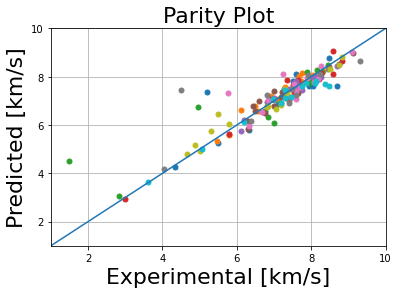

In [41]:
for i in range(len(test_outputs_list)):
   # plt.plot(train_outputs_list[i], train_preds_list[i], 'o')
    plt.plot(test_outputs_list[i], test_preds_list[i], 'o', markersize=5)

#plt.plot(df['D (exp) [km/s]'], df['D_KJ [km/s]'], 'o')

plt.xlabel('Experimental [km/s]', fontsize=22)
plt.ylabel('Predicted [km/s]', fontsize=22)
plt.title('Parity Plot', fontsize=22)

x = np.linspace(1, 10, 500)
plt.plot(x, x)
plt.ylim(1.0,10)
plt.xlim(1.0,10)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels


plt.grid()

In [ ]:
mse_train = new_model.evaluate([train_inputs[:, 0], train_inputs[:, 1], train_inputs[:, 2], train_inputs[:, 3], train_inputs[:, 4], train_inputs[:, 5]], train_outputs)
mse_test = new_model.evaluate([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:, 3], test_inputs[:, 4], test_inputs[:, 5]], test_outputs)

print (mse_train, mse_test)

In [ ]:
test_preds = np.around(new_model.predict([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:, 3], test_inputs[:, 4], test_inputs[:, 5]]),decimals=3)
train_preds = np.around(new_model.predict([train_inputs[:, 0], train_inputs[:, 1], train_inputs[:, 2], train_inputs[:, 3], train_inputs[:, 4], train_inputs[:, 5]]),decimals=3)

plt.plot(train_outputs, train_preds, 'o')
plt.plot(test_outputs, test_preds, 'o')
x = np.linspace(min(train_preds), max(train_preds), 500)
plt.plot(x, x)
plt.ylim(1.25,9.75)
plt.xlim(1.25,9.75)

plt.grid()

In [ ]:
preds = new_model.predict([inputs[0:1, 0], inputs[0:1,1], inputs[0:1, 2], inputs[0:1,3]]) 
print (preds, outputs[0])

In [ ]:
plt.plot(df['D (exp) [km/s]'], df['D_KJ [km/s]'], 'o')

x = np.linspace(min(df['D_KJ [km/s]']), max(df['D_KJ [km/s]']), 500)
plt.plot(x, x)
plt.ylim(1.25,9.75)
plt.xlim(1.25,9.75)

print('MSE_KJ',((df['D_KJ [km/s]'] - df['D (exp) [km/s]']) ** 2).mean() ** .5)

plt.grid()

In [ ]:
df['D (exp) [km/s]'].mean()

In [ ]:
1.04019229/7.132 * 100